# 1. Data Collection

For this project, I sellected five stocks and ETfs listed on the London Stock Exchange(LSE), namely BAE Systems (BAE), Experian (EXPN), Vanguard S&P 500 UCITS ETF (VUSA), iShares Core FTSE 100 UCITS ETF (ISF), and GlaxoSmithKline (GSK). the rationale for choosing these assets is both strategic and practical, aligning with 

In [2]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.stats import norm
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import itertools
import warnings
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


# filter only the SB3 Gym→Gymnasium compatibility warning
warnings.filterwarnings(
    "ignore",
    message="You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments.*",
    module="stable_baselines3.common.vec_env.patch_gym"
)

In [3]:
# Load and rename only the "Price" column from each asset
BAE = pd.read_csv("BAE.csv", parse_dates=["Date"], index_col="Date")[["Price"]].rename(columns={"Price": "BAE"})
EXPN = pd.read_csv("EXPN.csv", parse_dates=["Date"], index_col="Date")[["Price"]].rename(columns={"Price": "EXPN"})
VUSA = pd.read_csv("VUSA.csv", parse_dates=["Date"], index_col="Date")[["Price"]].rename(columns={"Price": "SP500"})
ISF = pd.read_csv("ISF.csv", parse_dates=["Date"], index_col="Date")[["Price"]].rename(columns={"Price": "FTSE100"})
GSK = pd.read_csv("GSK.csv", parse_dates=["Date"], index_col="Date")[["Price"]].rename(columns={"Price": "GSK"})

# Combine all into one DataFrame, sorted by date
df_all = pd.concat([BAE, EXPN, VUSA, ISF, GSK], axis=1).sort_index()

# Filter to data from 24 May 2012 onwards because VUSA only have data start from 24/5/2012
df = df_all[df_all.index >= pd.to_datetime("2012-05-24")].copy()

# Check result
print("Filtered Data from 24 May 2012:")
print(df.head())


Filtered Data from 24 May 2012:
               BAE   EXPN  SP500  FTSE100       GSK
Date                                               
2012-05-24  273.20  899.5  16.00    533.8  1,403.69
2012-05-25  272.40  903.0  16.05    534.1  1,411.16
2012-05-28  275.00  907.0  16.03    534.4  1,425.60
2012-05-29  277.40  919.0  16.23    538.2  1,418.13
2012-05-30  272.20  897.0  16.11    529.4  1,403.19


# 2. Data Preprocessing

In [4]:
df.isna().sum()

BAE        0
EXPN       0
SP500      0
FTSE100    0
GSK        0
dtype: int64

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3321 entries, 2012-05-24 to 2025-07-16
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAE      3321 non-null   object 
 1   EXPN     3321 non-null   object 
 2   SP500    3321 non-null   float64
 3   FTSE100  3321 non-null   float64
 4   GSK      3321 non-null   object 
dtypes: float64(2), object(3)
memory usage: 155.7+ KB
None


In [6]:
assets = df.columns

# --- Remove commas and convert object columns to float ---
for col in assets:
    df[col] = df[col].astype(str).str.replace(",", "").astype(float)

In [7]:
# Compute indicators
for asset in assets:
    # RSI
    df[f"{asset}_RSI"] = ta.rsi(df[asset], length=14)
    
    # MACD (just the MACD line)
    macd = ta.macd(df[asset])
    df[f"{asset}_MACD"] = macd["MACD_12_26_9"]
    
    # Volatility (rolling standard deviation)
    df[f"{asset}_VOL"] = df[asset].rolling(window=14).std()
    
    # Log returns
    df[f"{asset}_LOGRET"] = np.log(df[asset] / df[asset].shift(1))

# Drop rows with NaNs from indicator windows
df = df.dropna()

# Save for reference
df.to_csv("market_with_indicators.csv")

# --- Final checks ---
print("Final data preview:")
print(df.head())
print("\n Data types:")
print(df.dtypes)
print("\n Missing values check:")
print(df.isna().sum())

Final data preview:
              BAE   EXPN  SP500  FTSE100      GSK    BAE_RSI  BAE_MACD  \
Date                                                                     
2012-07-02  290.7  916.0  16.46    564.6  1465.93  63.822373  3.744630   
2012-07-03  290.7  923.5  16.64    569.6  1463.44  63.822373  4.024856   
2012-07-04  292.4  926.0  16.74    569.5  1467.42  65.591880  4.334151   
2012-07-05  295.3  954.0  16.80    570.3  1476.88  68.428739  4.758423   
2012-07-06  292.9  943.0  16.61    566.8  1487.84  63.744716  4.845150   

             BAE_VOL  BAE_LOGRET   EXPN_RSI  ...  SP500_VOL  SP500_LOGRET  \
Date                                         ...                            
2012-07-02  5.660607    0.007250  51.295006  ...   0.133869      0.003042   
2012-07-03  5.583039    0.000000  55.613588  ...   0.164617      0.010876   
2012-07-04  5.540996    0.005831  56.982808  ...   0.202213      0.005992   
2012-07-05  5.788512    0.009869  68.647984  ...   0.235922      0.003578   

Split	Purpose	Duration
train_df	Agent training (normal regime)	~7.5 years (stable trends)
stress_df	Stress test (crisis regime)	11 months (high volatility)
val_df	Hyperparameter tuning, model selection	2 years
test_df	Final evaluation on unseen data	2.5 years

In [8]:
# Split into testing and training data
train_df = df["2012-07-02":"2020-01-31"].copy()
val_df = df["2021-01-01":"2023-01-01"].copy()
stress_df = df["2020-02-01":"2020-12-31"].copy() # COIVD crash
test_df = df["2023-01-01":"2025-07-16"].copy()

train_df.shape

(1920, 25)

In [9]:
state_features = []
for asset in assets:
    state_features += [
        f"{asset}_RSI",
        f"{asset}_MACD",
        f"{asset}_VOL",
        f"{asset}_LOGRET"
    ]

# Fit and transform
scaler = StandardScaler()
train_df[state_features] = scaler.fit_transform(train_df[state_features])
val_df[state_features] = scaler.transform(val_df[state_features])
stress_df[state_features] = scaler.transform(stress_df[state_features])
test_df[state_features] = scaler.transform(test_df[state_features])

In [10]:
print("Train mean/std check (should be ~0/1):")
print(train_df[state_features].mean().round(2))
print(train_df[state_features].std().round(2))


Train mean/std check (should be ~0/1):
BAE_RSI           0.0
BAE_MACD          0.0
BAE_VOL           0.0
BAE_LOGRET       -0.0
EXPN_RSI         -0.0
EXPN_MACD         0.0
EXPN_VOL         -0.0
EXPN_LOGRET       0.0
SP500_RSI        -0.0
SP500_MACD        0.0
SP500_VOL        -0.0
SP500_LOGRET     -0.0
FTSE100_RSI       0.0
FTSE100_MACD     -0.0
FTSE100_VOL      -0.0
FTSE100_LOGRET    0.0
GSK_RSI           0.0
GSK_MACD         -0.0
GSK_VOL          -0.0
GSK_LOGRET       -0.0
dtype: float64
BAE_RSI           1.0
BAE_MACD          1.0
BAE_VOL           1.0
BAE_LOGRET        1.0
EXPN_RSI          1.0
EXPN_MACD         1.0
EXPN_VOL          1.0
EXPN_LOGRET       1.0
SP500_RSI         1.0
SP500_MACD        1.0
SP500_VOL         1.0
SP500_LOGRET      1.0
FTSE100_RSI       1.0
FTSE100_MACD      1.0
FTSE100_VOL       1.0
FTSE100_LOGRET    1.0
GSK_RSI           1.0
GSK_MACD          1.0
GSK_VOL           1.0
GSK_LOGRET        1.0
dtype: float64


# 3. EDA

First to understand the market behaviour, identify regime shifts and provide a macro context for my Reinforcement learning model. 
 ### 1. Price trends over time

<Axes: title={'center': 'Rebased Asset Prices (Base = 100)'}, xlabel='Date'>

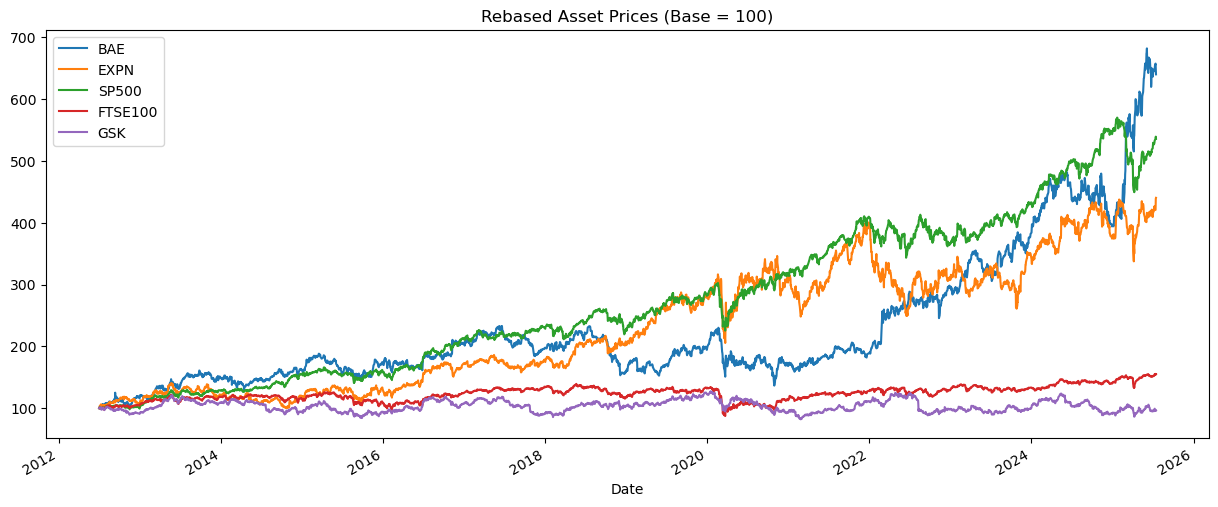

In [11]:
rebased = df[assets] / df[assets].iloc[0] * 100
rebased.plot(figsize=(15, 6), title="Rebased Asset Prices (Base = 100)")


Asset Growth Pattern

BAE	Strong, accelerating growth post-2021

EXPN Volatile but consistently uptrending

SP500 Smooth, steady compounding growth

FTSE100	Flat/stagnant (typical for UK large caps)

GSK	Very stable, almost no trend since 2015

In [12]:
print(df[assets].describe().T[["min", "max", "mean"]])


             min      max         mean
BAE       290.70  1982.00   664.133131
EXPN      916.00  4032.00  2128.327518
SP500      16.16    93.81    44.900482
FTSE100   492.80   877.30   697.877476
GSK      1202.78  1864.58  1515.666374


It will also be useful to see how the asset prices change over the course of the test period. Here, the plotted lines effectively show the outcome of a buy and hold strategy which initially purchases a single asset.

<Axes: title={'center': 'Rebased Asset Prices (Base = 100)'}, xlabel='Date'>

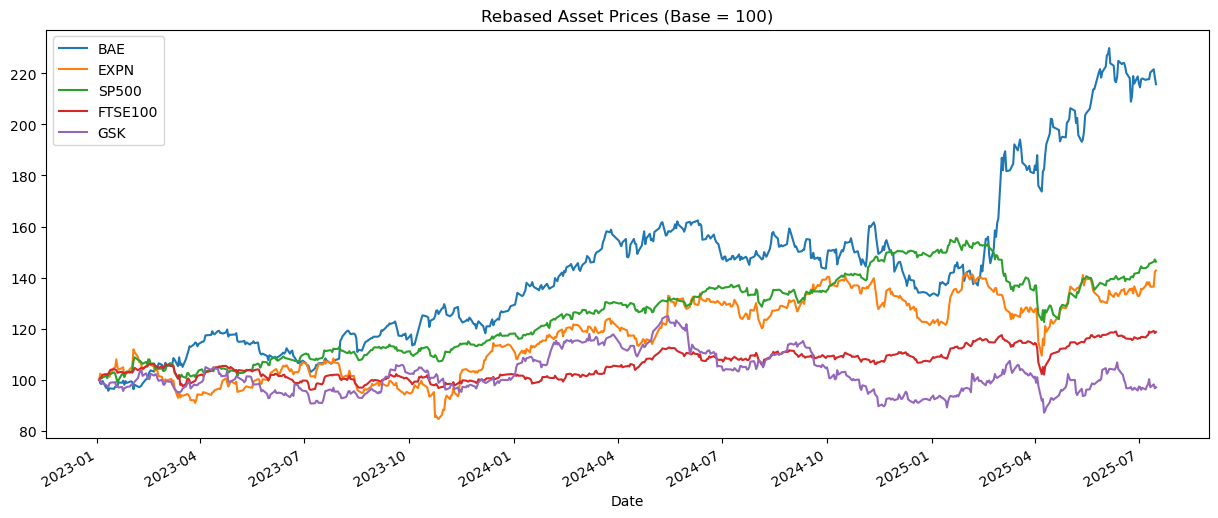

In [13]:
rebased = test_df[assets] / test_df[assets].iloc[0] * 100
rebased.plot(figsize=(15, 6), title="Rebased Asset Prices (Base = 100)")

### 2. Log Returns Distribution
Plot histograms or KDE of log returns to check fat tails, skewness, and volatility clustering.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


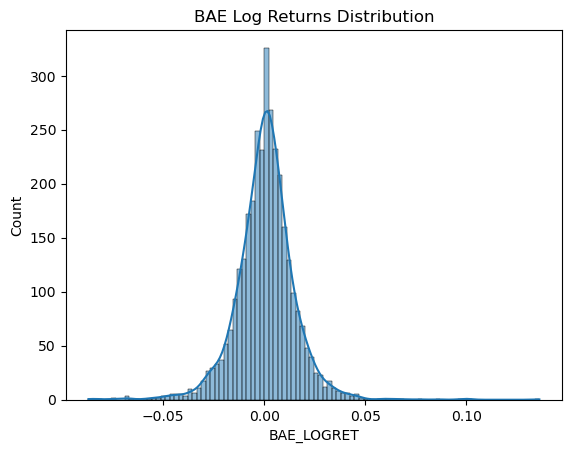

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


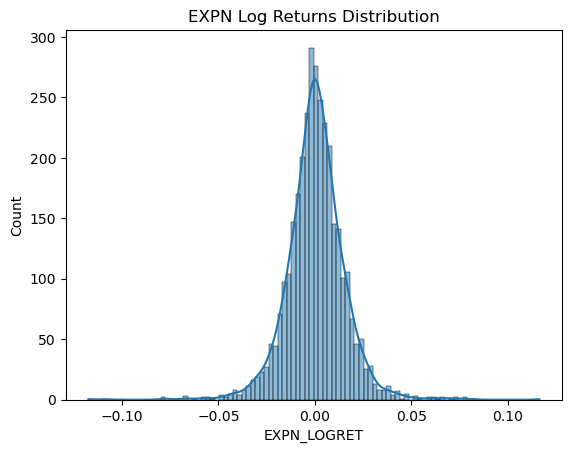

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


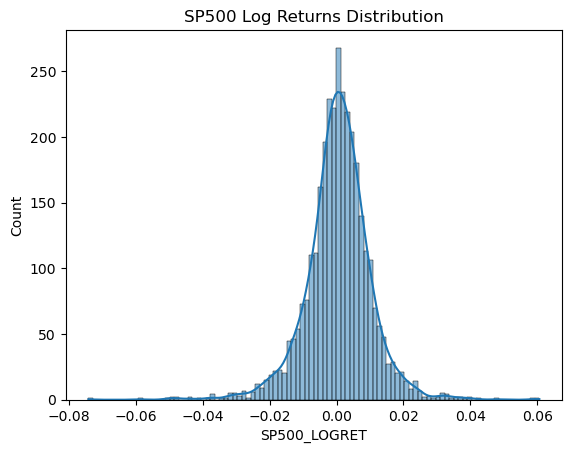

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


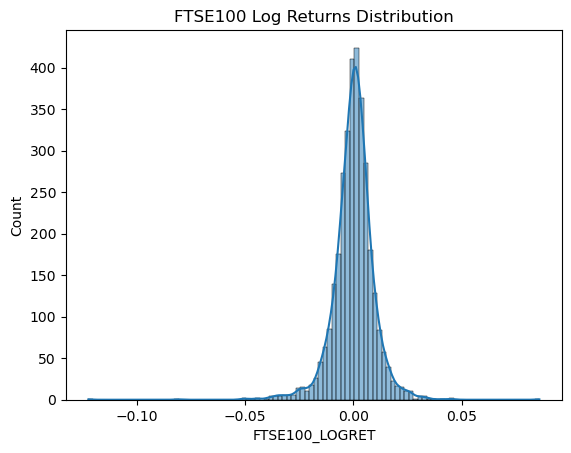

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


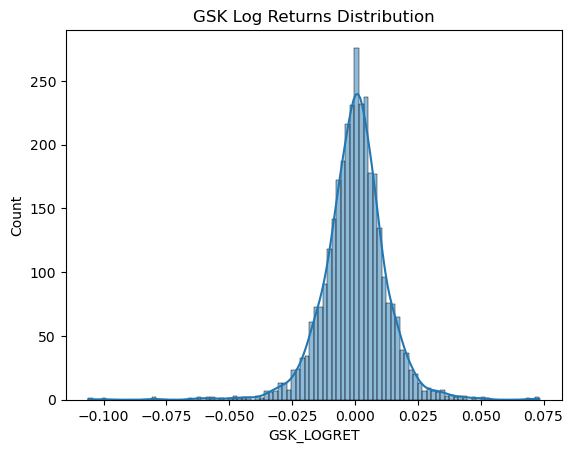

     Asset  Skewness  Kurtosis
0      BAE    0.1700    9.9200
1     EXPN   -0.0500    8.7200
2    SP500   -0.3600    7.7000
3  FTSE100   -1.0000   17.2700
4      GSK   -0.5200    9.0800
\begin{table}
\caption{Summary statistics of log returns}
\label{tab:logret_stats}
\begin{tabular}{lrr}
\toprule
Asset & Skewness & Kurtosis \\
\midrule
BAE & 0.170000 & 9.920000 \\
EXPN & -0.050000 & 8.720000 \\
SP500 & -0.360000 & 7.700000 \\
FTSE100 & -1.000000 & 17.270000 \\
GSK & -0.520000 & 9.080000 \\
\bottomrule
\end{tabular}
\end{table}



In [234]:
from scipy.stats import skew, kurtosis

# Store stats in a list
stats = []

for asset in assets:
    series = df[f"{asset}_LOGRET"].dropna()

    # Plot histogram + KDE
    sns.histplot(series, kde=True, bins=100)
    plt.title(f"{asset} Log Returns Distribution")
    plt.show()

    # Compute skewness & kurtosis
    s = skew(series)
    k = kurtosis(series, fisher=False)  # fisher=False → normal distribution kurtosis = 3
    stats.append((asset, round(s, 2), round(k, 2)))

# Convert results into DataFrame
stats_df = pd.DataFrame(stats, columns=["Asset", "Skewness", "Kurtosis"])
print(stats_df)

# Export to LaTeX
print(stats_df.to_latex(index=False,
                        caption="Summary statistics of log returns",
                        label="tab:logret_stats"))


### 3. Volatility Regimes
Plot volatility over time to see calm vs turbulent periods.

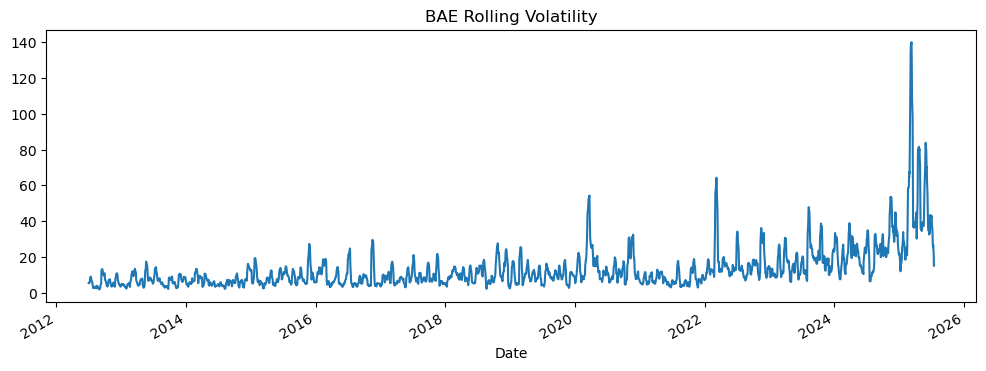

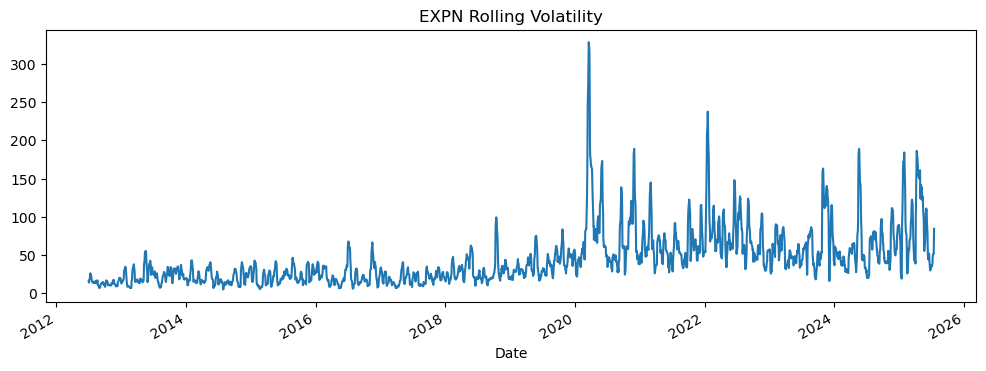

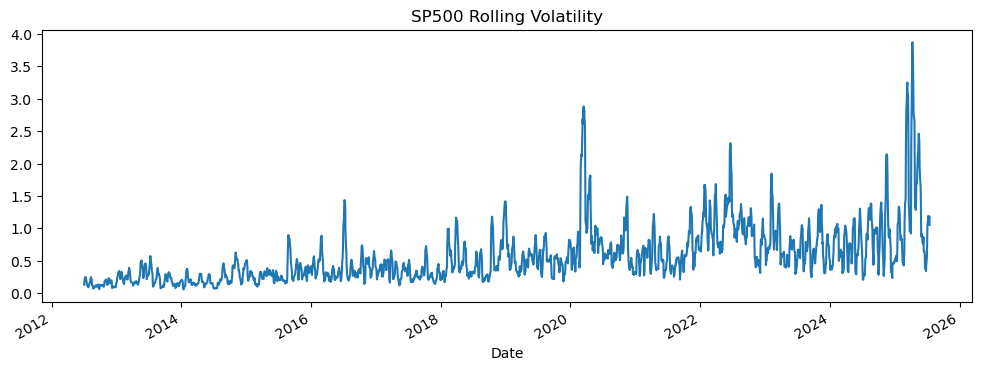

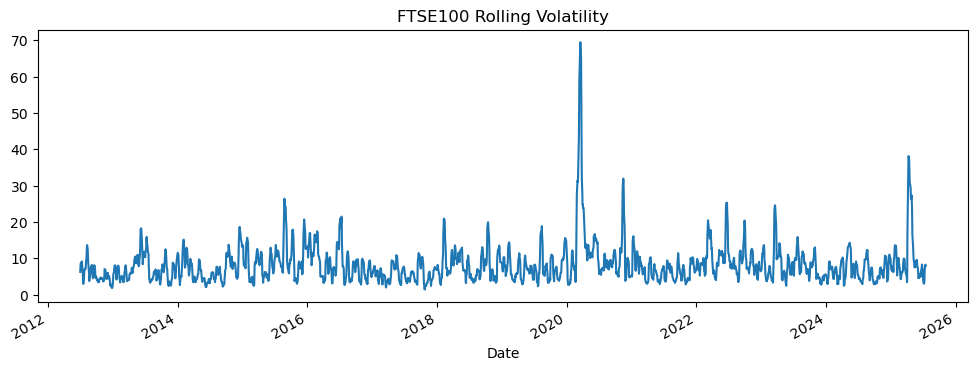

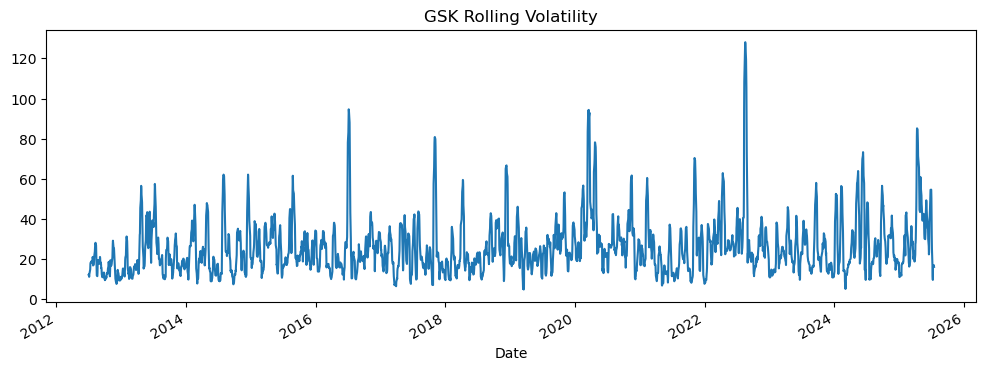

In [15]:
for asset in assets:
    df[f"{asset}_VOL"].plot(figsize=(12,4), title=f"{asset} Rolling Volatility")
    plt.show()


### 4. Technical Indicator Trends

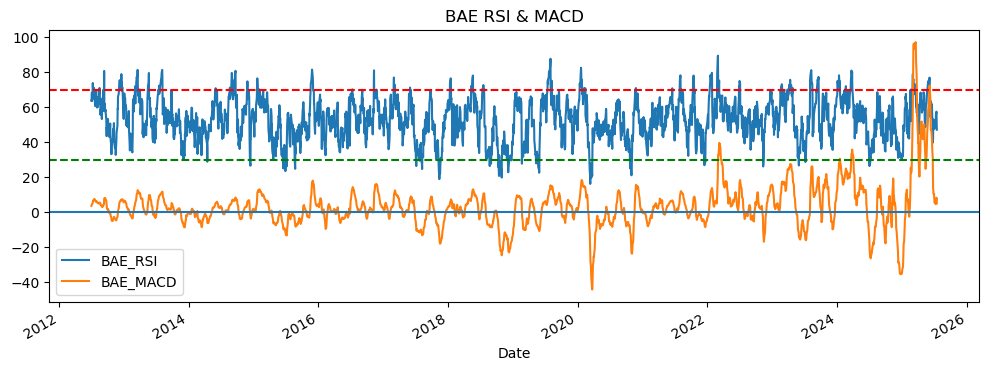

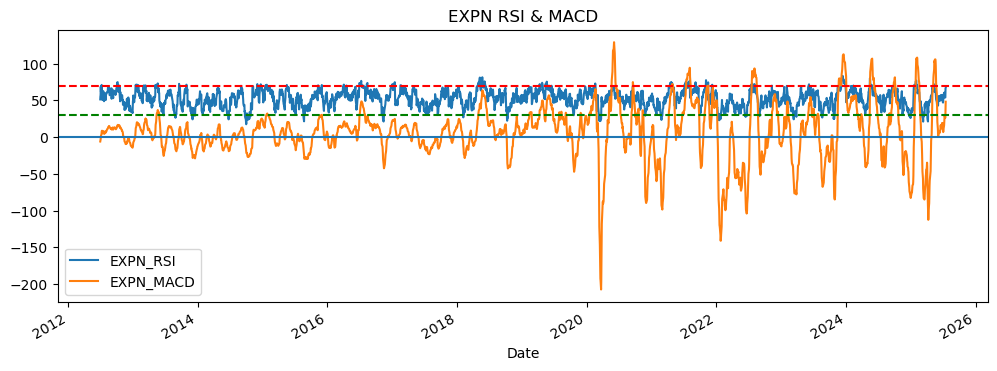

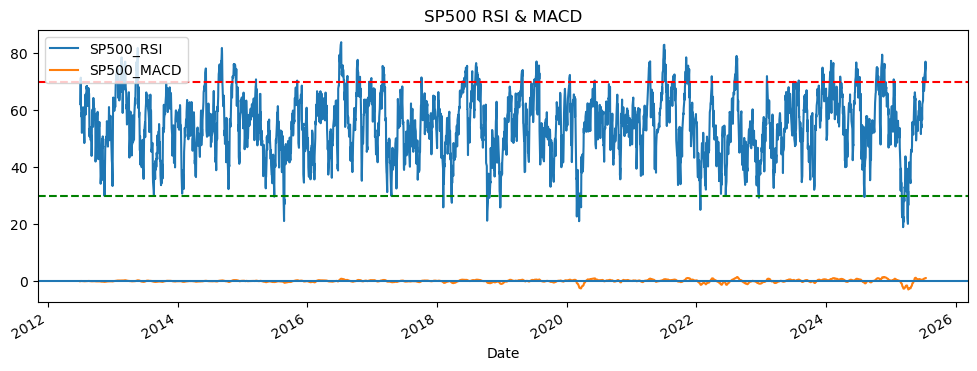

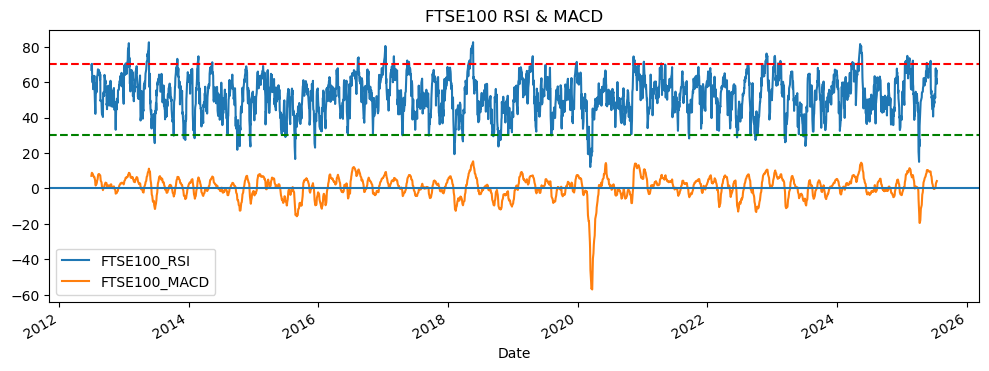

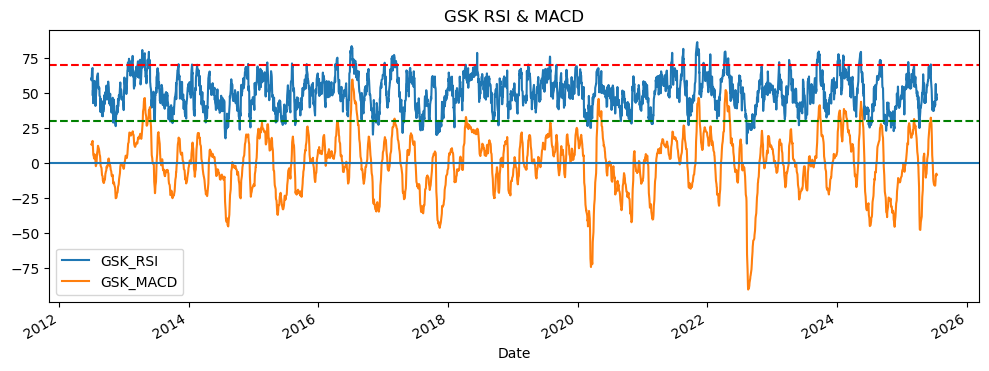

In [16]:
for asset in assets:
    df[[f"{asset}_RSI", f"{asset}_MACD"]].plot(figsize=(12,4), title=f"{asset} RSI & MACD")
    plt.axhline(70, color='red', linestyle='--')  # RSI overbought
    plt.axhline(30, color='green', linestyle='--')  # RSI oversold
    plt.axhline(0)
    plt.show()


### 5. Drawdowns
Visualise peak-to-trough declines for raw prices — helpful for understanding risk.

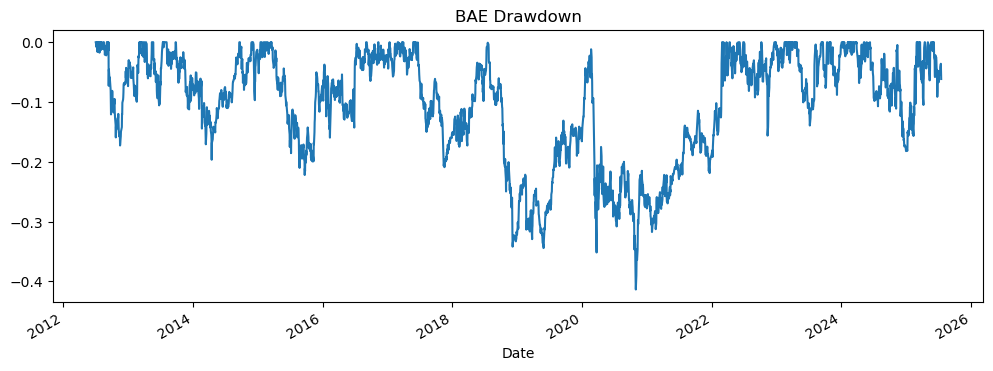

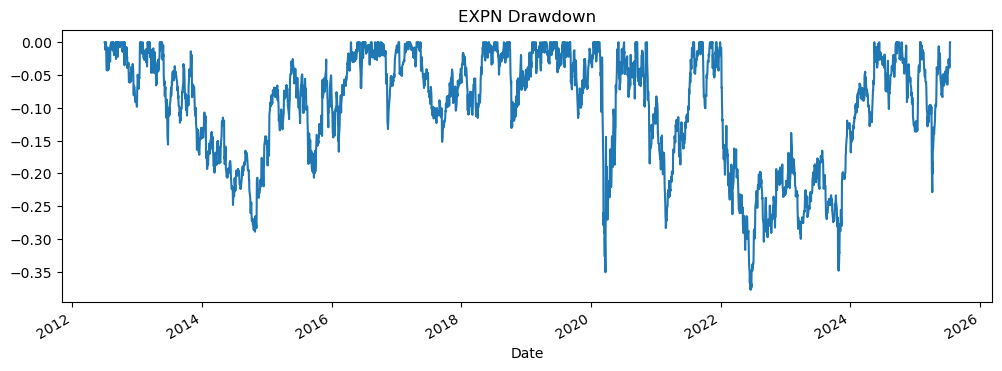

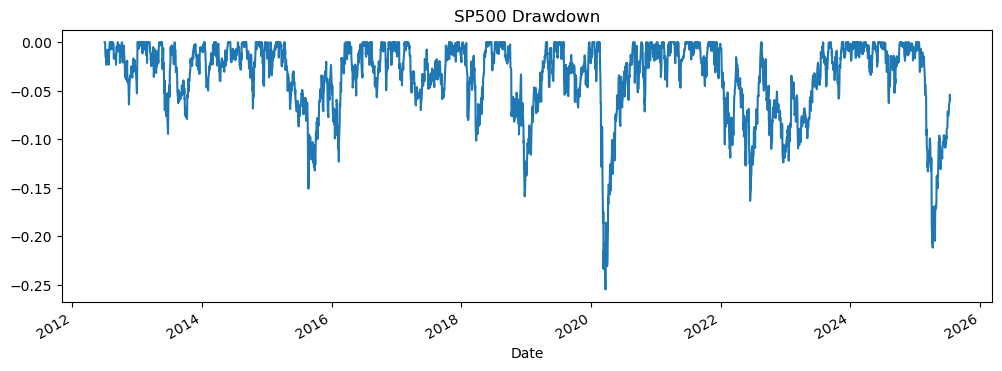

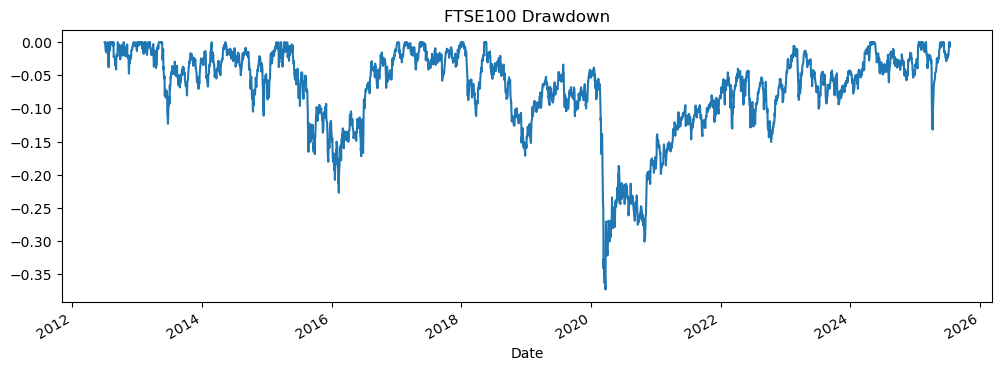

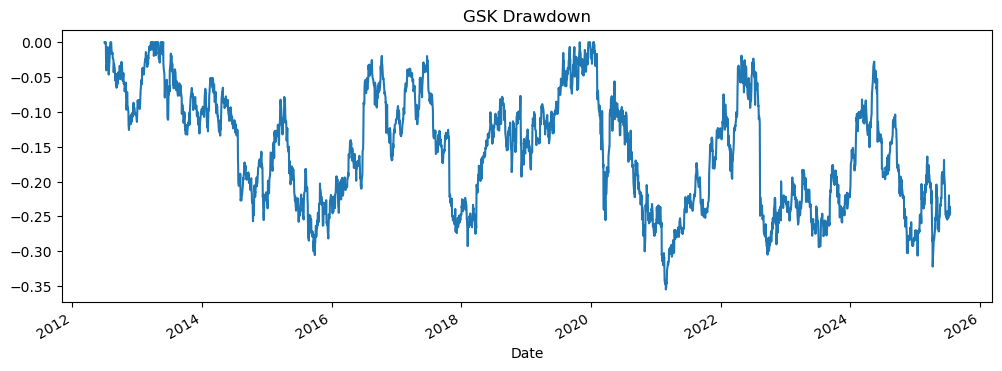

In [17]:
def plot_drawdown(asset):
    cum_returns = df[asset] / df[asset].iloc[0]
    running_max = cum_returns.cummax()
    drawdown = cum_returns / running_max - 1.0
    drawdown.plot(figsize=(12, 4), title=f"{asset} Drawdown")
    plt.show()

for asset in assets:
    plot_drawdown(asset)


### EDA on train_df 
Understand What the RL Agent Will Learn From
The reason why chose only to EDA the train_df: 
It’s the only data model “sees” during training.

Feature distributions here define model's baseline understanding of the market.

It ensures no leakage from future periods (like stress or test data).



In [18]:
# 1. Summary Statistics
summary_stats = train_df[state_features].describe().T
summary_stats['skew'] = train_df[state_features].skew()
summary_stats['kurtosis'] = train_df[state_features].kurt()


In [19]:
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
print(summary_stats)


                   count    mean    std     min     25%     50%    75%    max  \
BAE_RSI        1920.0000  0.0000 1.0003 -2.7300 -0.6636  0.0156 0.7256 2.8560   
BAE_MACD       1920.0000  0.0000 1.0003 -3.7688 -0.5562  0.0416 0.6639 2.5432   
BAE_VOL        1920.0000  0.0000 1.0003 -1.4546 -0.7294 -0.2516 0.4636 4.4923   
BAE_LOGRET     1920.0000 -0.0000 1.0003 -6.7983 -0.5443  0.0280 0.5435 7.8156   
EXPN_RSI       1920.0000 -0.0000 1.0003 -3.2594 -0.6986  0.1004 0.7505 2.5787   
EXPN_MACD      1920.0000  0.0000 1.0003 -3.0237 -0.6451  0.0520 0.5617 3.2800   
EXPN_VOL       1920.0000 -0.0000 1.0003 -1.4988 -0.7263 -0.2200 0.5212 5.6817   
EXPN_LOGRET    1920.0000  0.0000 1.0003 -5.3711 -0.5711  0.0011 0.5552 5.6780   
SP500_RSI      1920.0000 -0.0000 1.0003 -3.1905 -0.6867  0.0115 0.7184 2.7367   
SP500_MACD     1920.0000  0.0000 1.0003 -3.9020 -0.5732 -0.0488 0.6321 3.3235   
SP500_VOL      1920.0000 -0.0000 1.0003 -1.3913 -0.6899 -0.2324 0.4283 5.1708   
SP500_LOGRET   1920.0000 -0.

In [20]:
summary_stats.to_csv("train_summary_stats.csv")


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


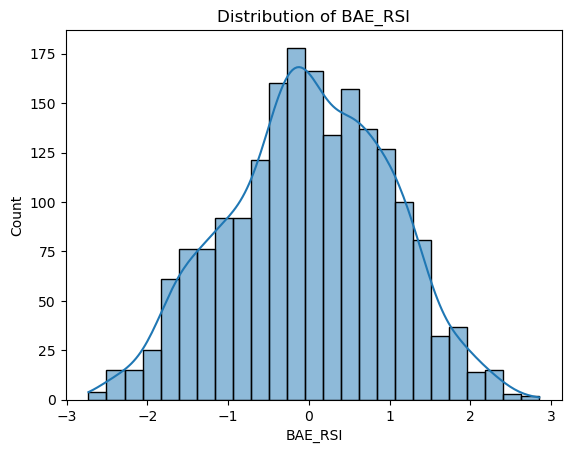

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


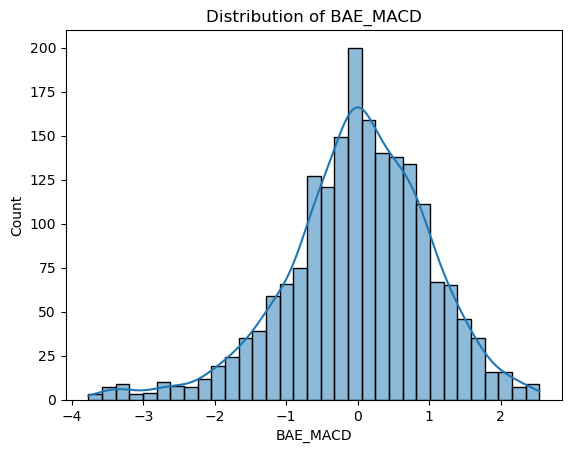

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


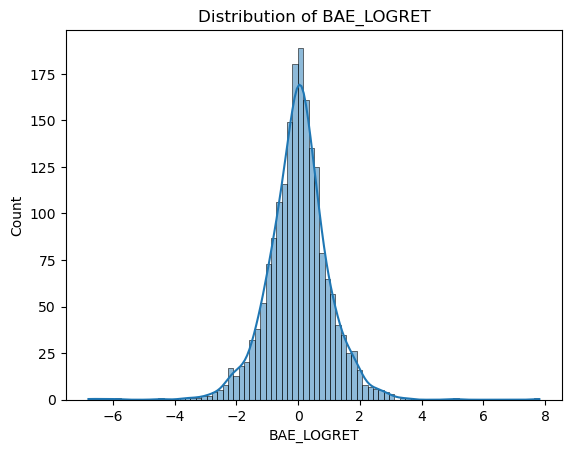

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


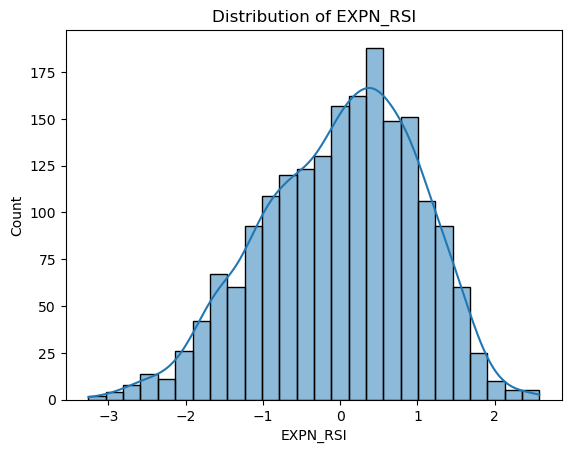

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


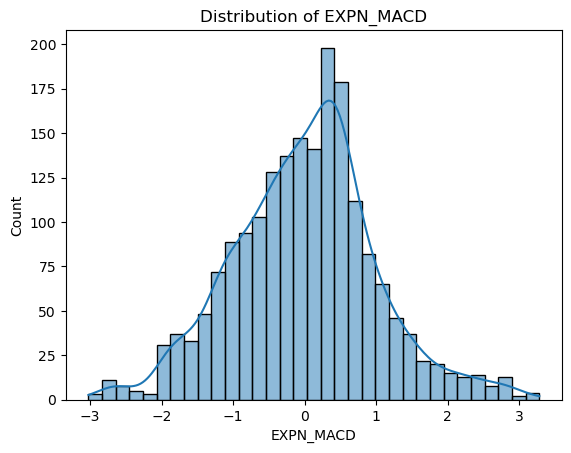

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


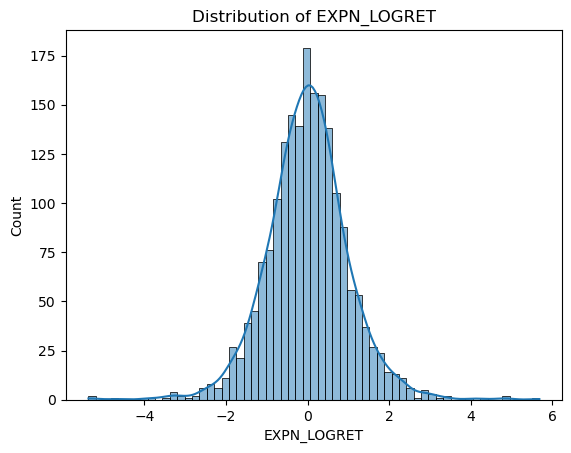

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


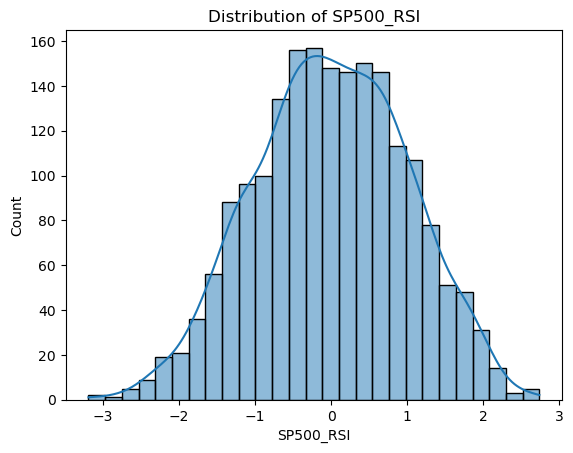

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


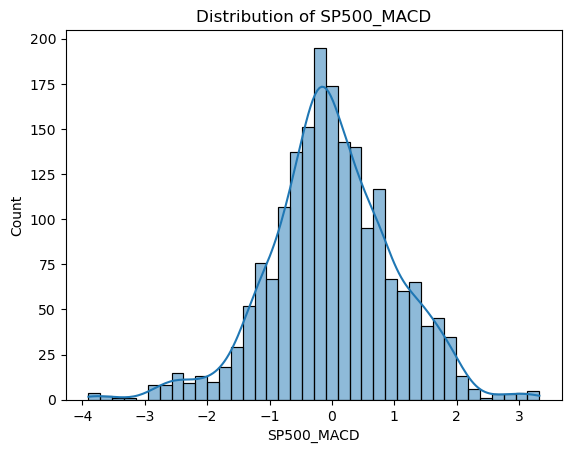

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


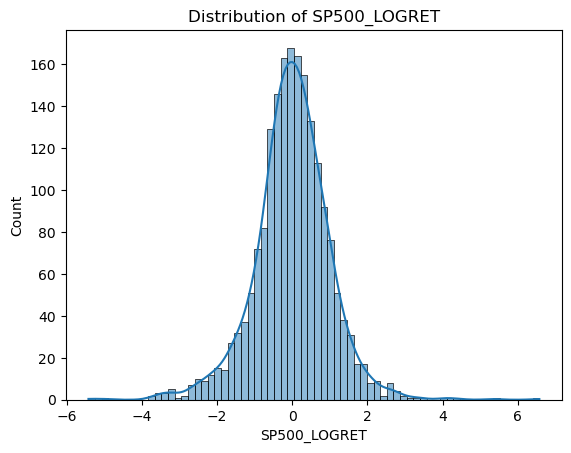

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


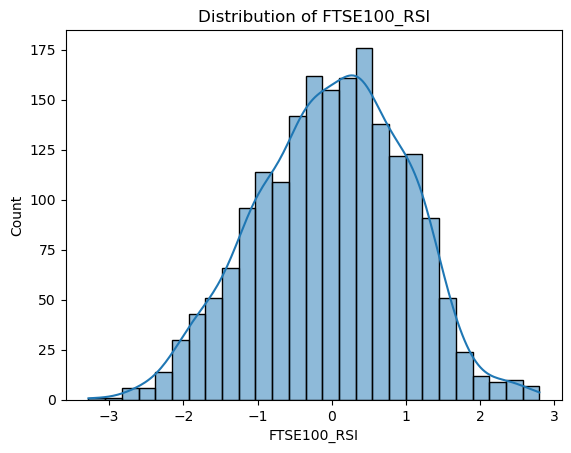

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


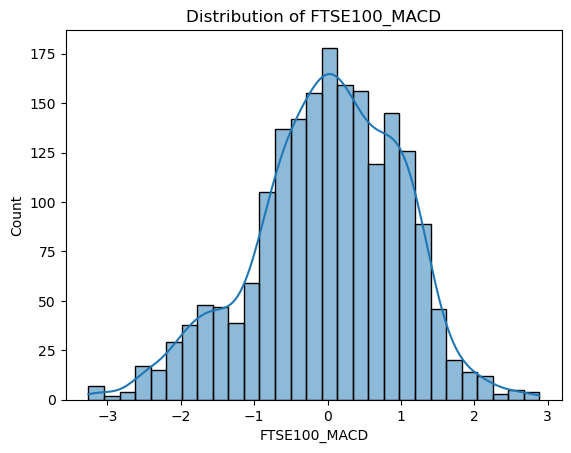

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


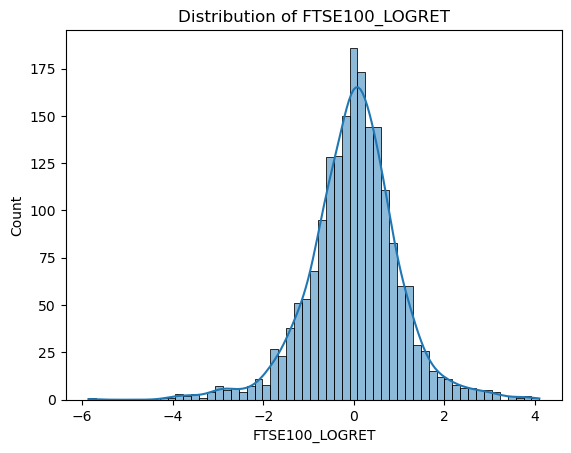

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


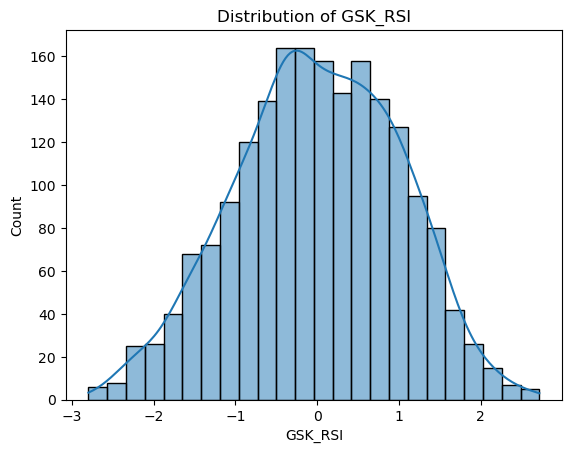

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


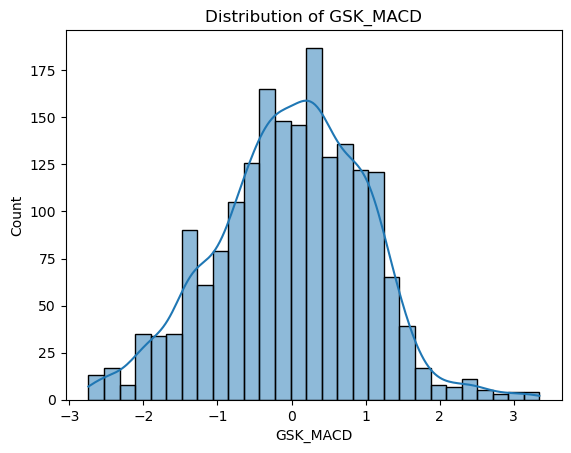

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


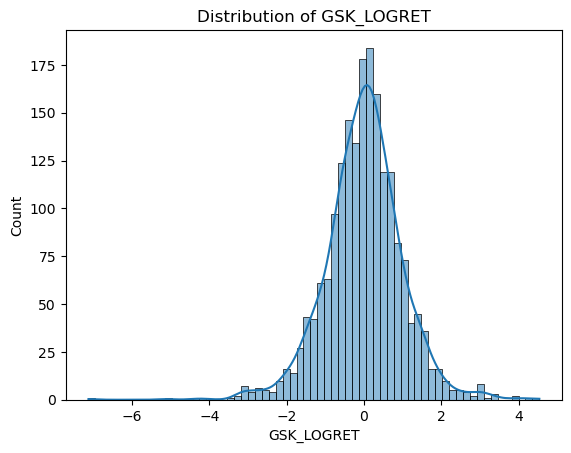

In [21]:
# 2. Distribution Plots (RSI, MACD, LOGRET)
for asset in assets:
    for feature in ["RSI", "MACD", "LOGRET"]:
        col = f"{asset}_{feature}"
        sns.histplot(train_df[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.show()


Spotting outliers

Understanding skew

Informing reward shaping

### 3. Rolling Volatility of Returns (Risk Proxy)

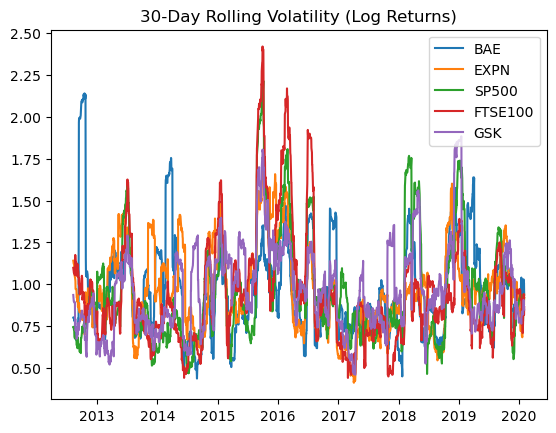

In [22]:
# 3. Rolling Volatility of Returns (Risk Proxy)
window = 30
for asset in assets:
    logret = train_df[f"{asset}_LOGRET"]
    rolling_vol = logret.rolling(window).std()
    plt.plot(rolling_vol, label=asset)

plt.title(f"{window}-Day Rolling Volatility (Log Returns)")
plt.legend()
plt.show()


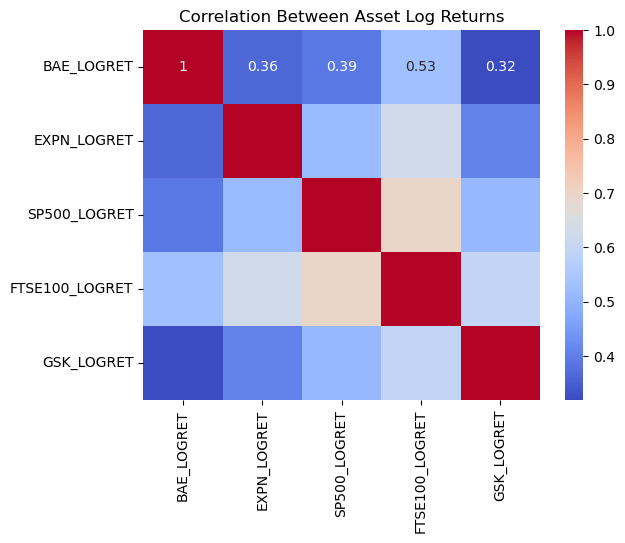

In [23]:
# 4. Pairwise Asset Correlation (Risk/Exposure Insight)
logret_cols = [f"{asset}_LOGRET" for asset in assets]
corr_matrix = train_df[logret_cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Between Asset Log Returns")
plt.show()


FTSE100 & SP500	0.66	Strongest correlation – both are broad market indices
BAE & FTSE100	0.53	High – BAE is UK-listed, sensitive to macro UK sentiment
SP500 & EXPN	0.39	Moderate – EXPN may have global exposure
GSK & others	0.32 and below	Low – GSK appears more idiosyncratic and less sensitive to market-wide movements
BAE & GSK	0.32	Very low co-movement – supports diversification
EXPN & BAE	0.36	Moderate – possibly sectoral or domestic exposure overlap

<Axes: title={'center': 'Smoothed RSI Over Time'}, xlabel='Date'>

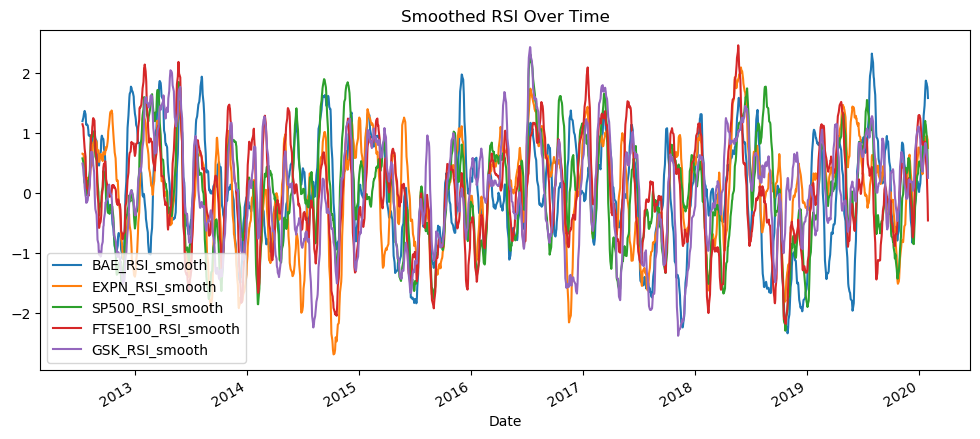

In [24]:
for asset in assets:
    train_df[f"{asset}_RSI_smooth"] = train_df[f"{asset}_RSI"].rolling(window=10).mean()

train_df[[f"{asset}_RSI_smooth" for asset in assets]].plot(title="Smoothed RSI Over Time", figsize=(12, 5))


In [26]:
# 6. Bear/Bull Regime Flagging 
def classify_regime(x):
    if x < -0.03:
        return "Bear"
    elif x > 0.03:
        return "Bull"
    else:
        return "Sideways"

for asset in assets:
    col = f"{asset}_LOGRET"
    train_df[f"{asset}_regime"] = train_df[col].apply(classify_regime)


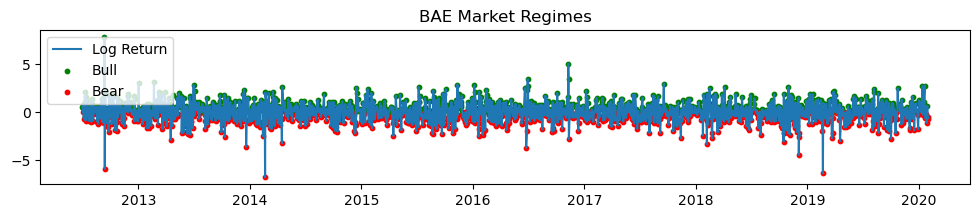

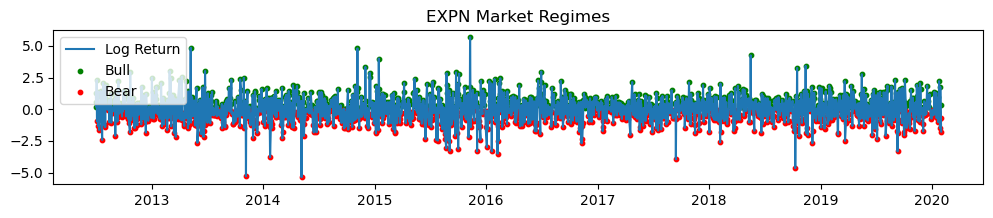

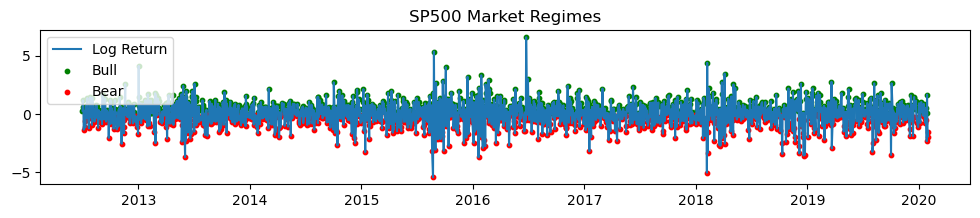

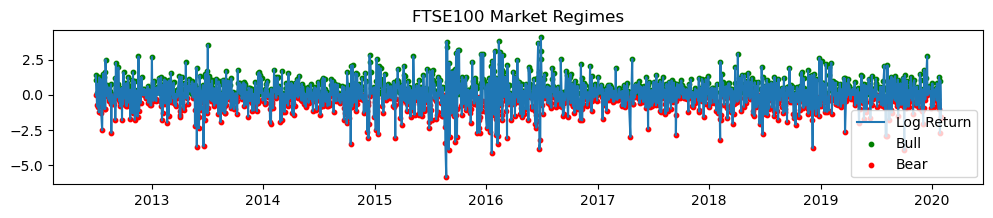

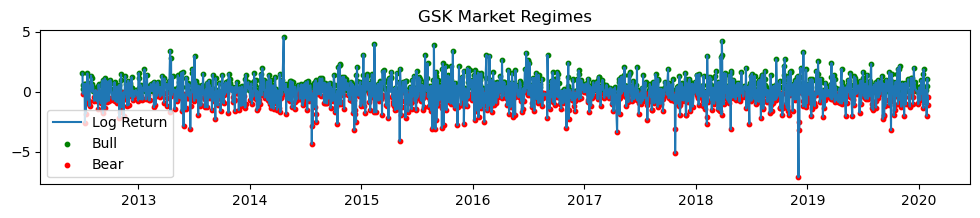

In [27]:
for asset in assets:
    plt.figure(figsize=(12, 2))
    plt.title(f"{asset} Market Regimes")
    plt.plot(train_df.index, train_df[f"{asset}_LOGRET"], label='Log Return')
    
    bull = train_df[train_df[f"{asset}_regime"] == "Bull"]
    bear = train_df[train_df[f"{asset}_regime"] == "Bear"]
    
    plt.scatter(bull.index, bull[f"{asset}_LOGRET"], color='green', label='Bull', s=10)
    plt.scatter(bear.index, bear[f"{asset}_LOGRET"], color='red', label='Bear', s=10)
    
    plt.legend()
    plt.show()


In [28]:
for asset in assets:
    print(f"{asset} regime counts:")
    print(train_df[f"{asset}_regime"].value_counts())
    print()


BAE regime counts:
BAE_regime
Bull        955
Bear        924
Sideways     41
Name: count, dtype: int64

EXPN regime counts:
EXPN_regime
Bear        941
Bull        927
Sideways     52
Name: count, dtype: int64

SP500 regime counts:
SP500_regime
Bull        948
Bear        915
Sideways     57
Name: count, dtype: int64

FTSE100 regime counts:
FTSE100_regime
Bull        967
Bear        893
Sideways     60
Name: count, dtype: int64

GSK regime counts:
GSK_regime
Bull        950
Bear        910
Sideways     60
Name: count, dtype: int64



1. Bull vs Bear Are Well Balanced
I’ve avoided imbalance problems, which is great for training RL agent in all market conditions.

Both uptrends and downtrends are well represented → agent can learn when to go long, short, or stay out.



# Baseline Model Inclusion
## Buy & Hold baseline strategy

In [29]:
def performance_metrics(series):
    returns = pd.Series(series).pct_change().dropna()
    cumulative_return = (series.iloc[-1] - series.iloc[0]) / series.iloc[0]
    sharpe = returns.mean() / returns.std() * np.sqrt(252)
    max_drawdown = ((series / series.cummax()) - 1).min()
    return cumulative_return,sharpe,max_drawdown

def analyse_results(results,model_name='',verbose=True):
    metrics = np.zeros(3)
    for col in results.columns:
        metrics += np.array(performance_metrics(results[col]))
    metrics /= len(results.columns)

    # --- Plot ---
    if verbose:
        plt.figure(figsize=(12,6))

        for col in results.columns:
            plt.plot(results.index, results[col], color='blue', alpha=0.5, linewidth=1)

        plt.title(f"{model_name} Monte Carlo Portfolio Value Paths")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value (£)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
        print("Cumulative return: ",metrics[0]*100,"%")
        print("Sharpe ratio: ",metrics[1])
        print("Max drawdown: ",metrics[2])
    
    return {'cumulative_return':metrics[0],'sharpe':metrics[1],'max_drawdown':metrics[2]}

In [30]:
# Buy and Hold Portfolio Simulation
def buy_and_hold_series(df, assets, initial_cash=10000):
    initial_prices = df.iloc[0][assets].values
    weights = [1 / len(assets)] * len(assets)
    units = (initial_cash * np.array(weights)) / initial_prices

    portfolio_values = df[assets].values @ units
    portfolio_series = pd.Series(portfolio_values, index=df.index)
    return portfolio_series


In [31]:
def analyse_single_series(series, model_name='', verbose=True):
    metrics = performance_metrics(series)

    if verbose:
        plt.figure(figsize=(12, 6))
        plt.plot(series, label=model_name, color='blue')
        plt.title(f"{model_name} Portfolio Value")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value (£)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        print(f"{model_name} Metrics")
        print("Cumulative return: ",metrics[0]*100,"%")
        print("Sharpe ratio: ",metrics[1])
        print("Max drawdown: ",metrics[2])
    
    return metrics


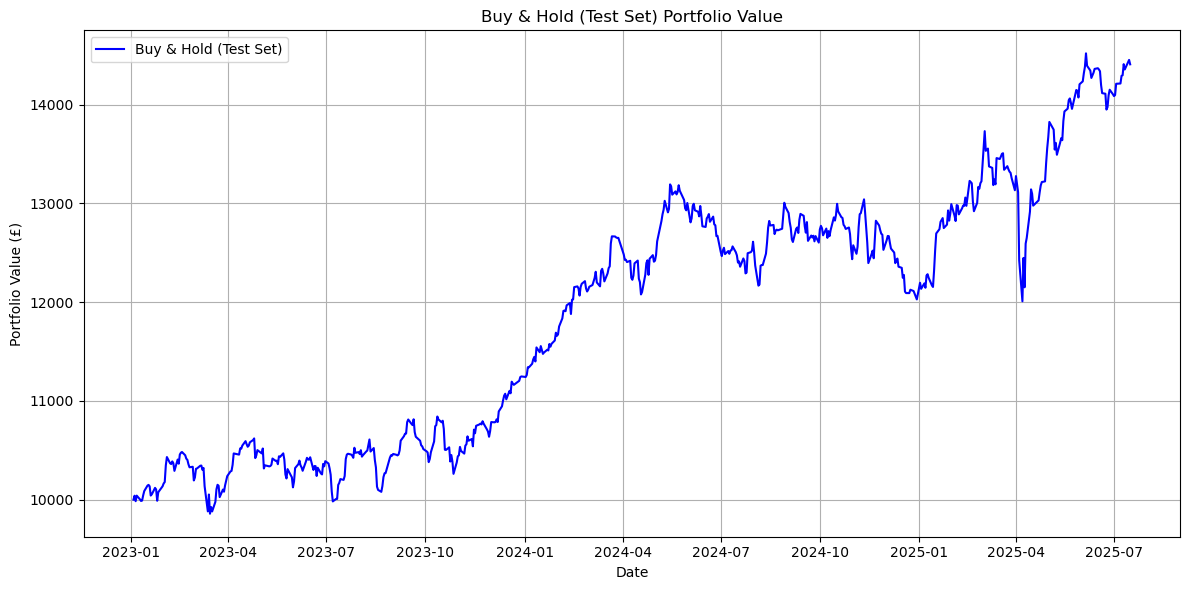

Buy & Hold (Test Set) Metrics
Cumulative return:  44.08595522472915 %
Sharpe ratio:  1.2114845607762332
Max drawdown:  -0.12546673370536499


In [32]:
# Simulate Buy & Hold
bnh_series = buy_and_hold_series(test_df, assets)

# Analyse and plot
bnh_metrics = analyse_single_series(bnh_series, model_name="Buy & Hold (Test Set)")


In [33]:
bnh_series.to_csv("BuyHold_backtest_portfolio.csv")


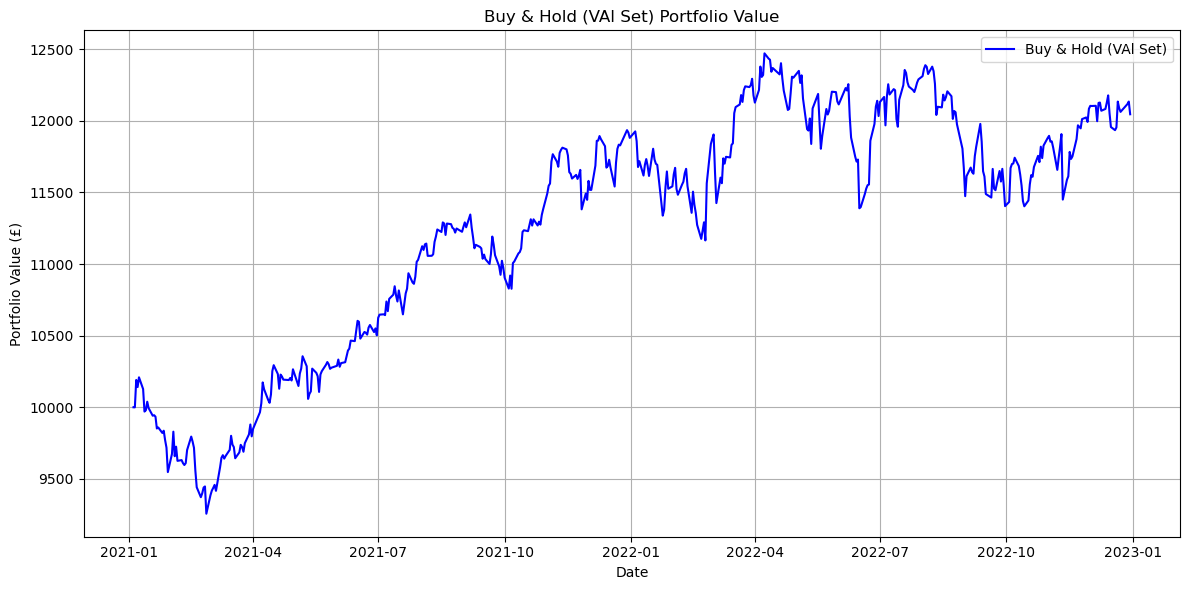

Buy & Hold (VAl Set) Metrics
Cumulative return:  20.46311676339785 %
Sharpe ratio:  0.7750018108924422
Max drawdown:  -0.09330620704243142


In [34]:
# Run the Buy-and-Hold on validation set strategy
bnh_series_val = buy_and_hold_series(val_df, assets)

# Analyse and plot
bnh_val_metrics = analyse_single_series(bnh_series_val, model_name="Buy & Hold (VAl Set)")



### Baseline 2: Logistic Regression

Why LR: Simplicity and interpretability, LR is simple, fast and transparent. It gives probabilities of upward/downward movement. And it is easily interpret feature importance via coefficients. 
In finance, interpretablity is valued: why did the model buy this asset? LR is able to answer that. 
You're predicting whether the next return is positive (1) or negative (0).
That’s a classification task, and logistic regression is designed for binary classification.

Compare to Random Forests or XGBoost can easy get overfit on noisy financial data. LogReg performs surprisingly well in high-noise, low-signal environments like finance. 

It is a common baseline in Quant Literature, is a standard benchmark model in quant finance and academic papers. It is useful to test whether more complex models are actually learning or just fitting noise. 

How Logistic Regression work? 
It can predict what's the chance the price will go up tomorrow? 

If tomorrow’s LOGRET > 0, we label it as 1 (up).

If LOGRET ≤ 0 → label 0 (down).

Logistic Regression works by taking a set of input features — such as RSI, MACD, VOL, and today’s LOGRET — and computing a weighted sum of them along with a bias term. Mathematically, this is represented as:
  z = w₀ + w₁·RSI + w₂·MACD + w₃·VOL + w₄·LOGRET,
where w₀ is the intercept, and w₁ to w₄ are the learned coefficients from the training data. This value z is then passed through a sigmoid function,
  ŷ = 1 / (1 + e^(–z)),
which transforms it into a number between 0 and 1 — interpreted as the probability that the asset’s price will go up in the next time step. Finally, the model makes a binary prediction: if the probability ŷ > 0.5, it predicts a positive return (class 1, "price will go up"); otherwise, it predicts a negative return (class 0, "price will go down"). This threshold can be adjusted (e.g., 0.6) to make the strategy more selective and avoid low-confidence trades.

In [36]:
# Create targets for train, val, test, and stress sets
for asset in assets:
    for df_ in [train_df, val_df, test_df, stress_df]:
        df_[f"{asset}_target"] = (df_[f"{asset}_LOGRET"].shift(-1) > 0).astype(int)

# Drop rows with missing target values (due to shift(-1))
for df_ in [train_df, val_df, test_df, stress_df]:
    df_.dropna(subset=[f"{asset}_target" for asset in assets], inplace=True)


In [37]:

# --- STEP 2: Train Logistic Regression on train_df ONLY ---
def train_final_models(train_df, test_df, assets):
    results = {}

    for asset in assets:
        features = [f"{asset}_RSI", f"{asset}_MACD", f"{asset}_VOL", f"{asset}_LOGRET"]
        target = f"{asset}_target"

        model = LogisticRegression(max_iter=200)

        model.fit(train_df[features], train_df[target])
        preds = model.predict(test_df[features])
        acc = accuracy_score(test_df[target], preds)

        results[asset] = {
            "accuracy": acc,
            "predictions": preds,
            "model": model
        }

    return results

# Train and predict
lr_results = train_final_models(train_df, test_df, assets)

In [38]:
# STEP 3: Simulate trading strategy
def simulate_logistic_strategy(test_df, asset, preds, initial_cash=10000):
    prices = test_df[asset].values
    cash = initial_cash
    holdings = 0
    values = []

    for i in range(len(preds)):
        price = prices[i]
        if preds[i] == 1 and cash > 0:
            holdings = cash / price
            cash = 0
        elif preds[i] == 0 and holdings > 0:
            cash = holdings * price
            holdings = 0
        total_value = cash + holdings * price
        values.append(total_value)

    return pd.Series(values, index=test_df.index)


# STEP 4: Simulate for each asset and combine
lr_portfolios = {}
for asset, res in lr_results.items():
    lr_portfolios[asset] = simulate_logistic_strategy(test_df, asset, res["predictions"])

# Equal-weighted portfolio
lr_portfolio_total = pd.DataFrame(lr_portfolios).mean(axis=1)


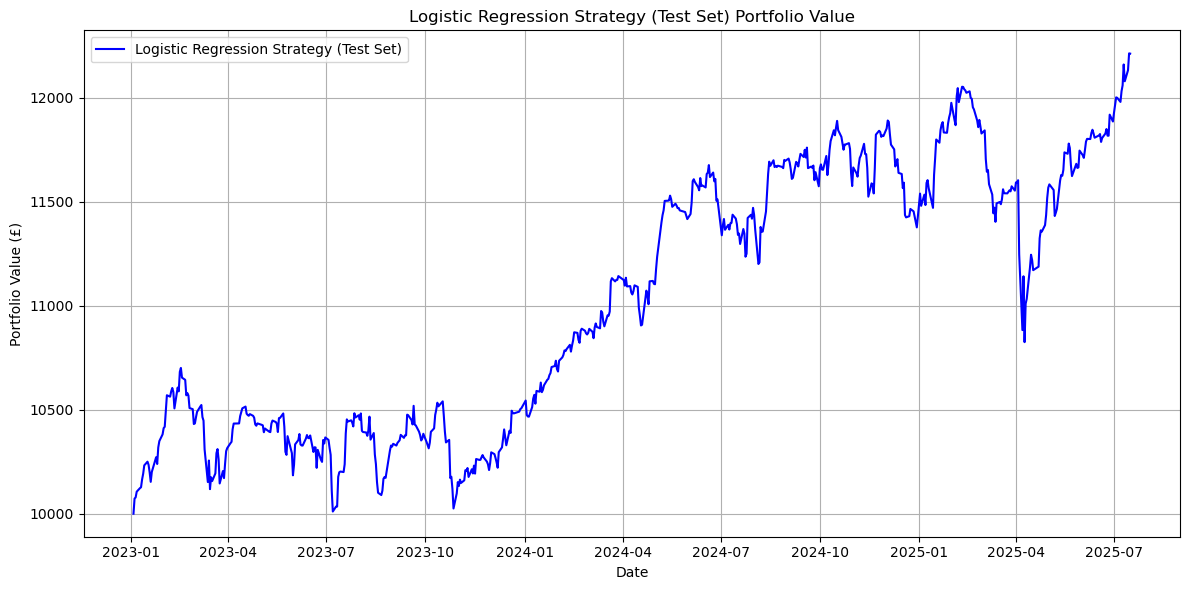

Logistic Regression Strategy (Test Set) Metrics
Cumulative return:  22.113464546207762 %
Sharpe ratio:  0.985471906520102
Max drawdown:  -0.10185238920725104


In [39]:
# Run Buy & Hold strategy on the stress set 
lr_metrics = analyse_single_series(lr_portfolio_total, model_name="Logistic Regression Strategy (Test Set)")


In [40]:
# Save predictions and portfolio value
lr_portfolio_total.to_csv("LR_backtest_portfolio.csv")


### Support Vector Machine (SVM)

In [250]:
# 1. Hyperparameter Tuning
# ---------------------------
def tune_svm_hyperparams(train_df, val_df, assets):
    best_params = {}
    scaler = StandardScaler()

    for asset in assets:
        features = [f"{asset}_RSI", f"{asset}_MACD", f"{asset}_VOL", f"{asset}_LOGRET"]
        target = f"{asset}_target"

        X_train, y_train = train_df[features], train_df[target]
        X_val, y_val = val_df[features], val_df[target]

        # Scale features
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        param_grid = {
            "C": [0.1, 1, 10],
            "gamma": ["scale", 0.1, 1],
            "kernel": ["rbf"]
        }

        grid = GridSearchCV(SVC(), param_grid, scoring='accuracy', cv=3)
        grid.fit(X_train, y_train)

        best_params[asset] = grid.best_params_
        print(f"Best SVM params for {asset}: {grid.best_params_}")

    return best_params

In [251]:
# 2. Train Final SVM Models
# ---------------------------
def train_final_svm_models(train_df, test_df, assets, best_params): 
    results = {}
    scaler = StandardScaler()

    for asset in assets:
        features = [f"{asset}_RSI", f"{asset}_MACD", f"{asset}_VOL", f"{asset}_LOGRET"]
        target = f"{asset}_target"

        X_train, y_train = train_df[features], train_df[target]
        X_test, y_test = test_df[features], test_df[target]

        # Scale
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model = SVC(kernel='rbf', C=best_params[asset]["C"],
                    gamma=best_params[asset]["gamma"]) 
        
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, preds)

        results[asset] = {
            "accuracy": acc,
            "predictions": preds,
            "model": model
        }

    return results

In [252]:
# 3. Portfolio Simulation
# ---------------------------
def simulate_svm_portfolio(test_df, assets, svm_results, initial_cash=10000,
                           transaction_cost=0.001, slippage=0.0005):
    cash = initial_cash
    holdings = {asset: 0 for asset in assets}
    portfolio_values = []

    for t in range(len(test_df)):
        prices = test_df.loc[test_df.index[t], assets].values

        # signals from each asset's SVM model
        signals = {asset: svm_results[asset]["predictions"][t] for asset in assets}

        # equal weight target allocation
        total_value = cash + sum(holdings[a] * test_df.loc[test_df.index[t], a] for a in assets)
        target_value = total_value / len(assets)

        for i, asset in enumerate(assets):
            price = prices[i]

            if signals[asset] == 1:
                # target holding in this asset
                desired_units = target_value / price
                diff_units = desired_units - holdings[asset]

                # apply transaction cost + slippage
                if diff_units > 0:  # buy
                    cost = diff_units * price * (1 + transaction_cost + slippage)
                    if cash >= cost:
                        cash -= cost
                        holdings[asset] += diff_units
                else:  # sell
                    revenue = -diff_units * price * (1 - transaction_cost - slippage)
                    cash += revenue
                    holdings[asset] += diff_units

            else:  # signal = 0 → fully liquidate position
                if holdings[asset] > 0:
                    revenue = holdings[asset] * price * (1 - transaction_cost - slippage)
                    cash += revenue
                    holdings[asset] = 0

        # compute portfolio value
        portfolio_value = cash + sum(holdings[a] * test_df.loc[test_df.index[t], a] for a in assets)
        portfolio_values.append(portfolio_value)

    return pd.Series(portfolio_values, index=test_df.index, name="SVM Portfolio")



Best SVM params for BAE: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Best SVM params for EXPN: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best SVM params for SP500: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVM params for FTSE100: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Best SVM params for GSK: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


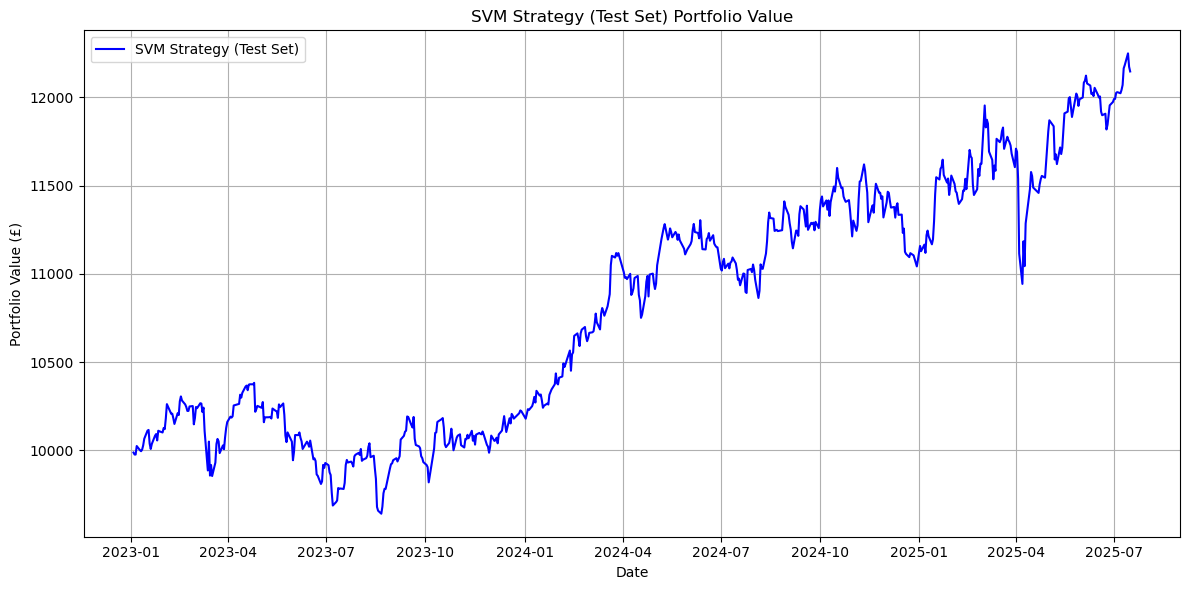

SVM Strategy (Test Set) Metrics
Cumulative return:  21.606489617990157 %
Sharpe ratio:  0.8845644381120323
Max drawdown:  -0.08453421096445246


In [253]:
# 4. Run Full Pipeline
# ---------------------------
# Step 1: Tune params
best_params = tune_svm_hyperparams(train_df, val_df, assets)

# Step 2: Train final SVMs on train + test
svm_results = train_final_svm_models(train_df, test_df, assets, best_params)

# Step 3: Simulate portfolio
svm_portfolio_total = simulate_svm_portfolio(test_df, assets, svm_results)

# Step 4: Analyse metrics
svm_metrics_test = analyse_single_series(svm_portfolio_total, model_name="SVM Strategy (Test Set)")


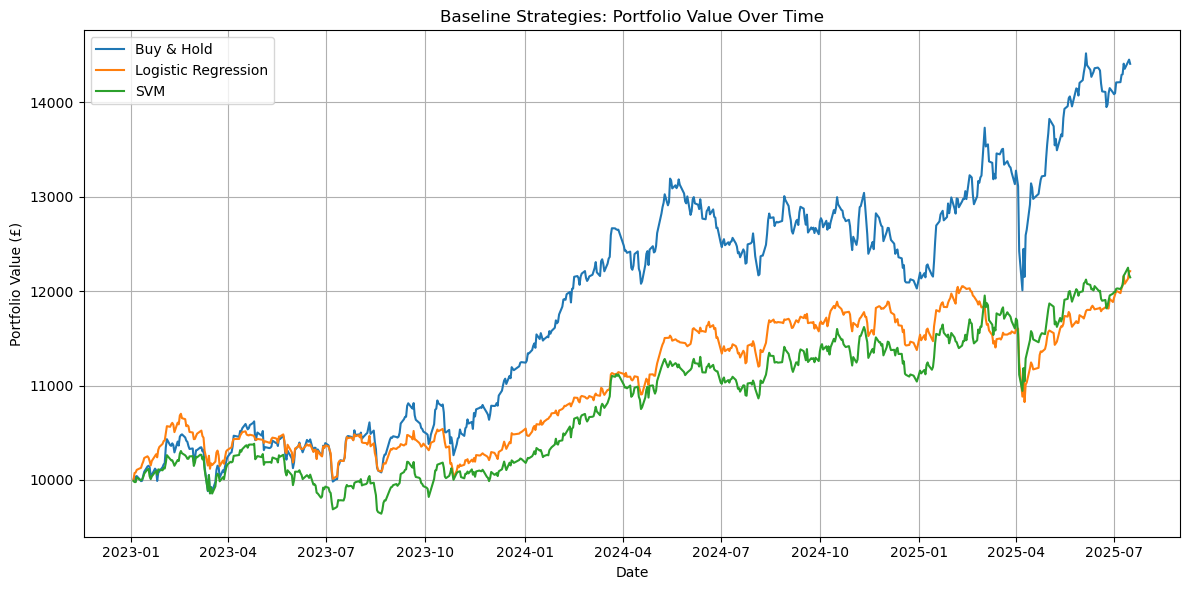

In [254]:
plt.figure(figsize=(12, 6))

# Plot each baseline model
plt.plot(bnh_series, label="Buy & Hold")
plt.plot(lr_portfolio_total, label="Logistic Regression")
plt.plot(svm_portfolio_total, label="SVM")

plt.title("Baseline Strategies: Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (£)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Reinforcement Learning

Define a custom OpenAI Gym environment so that a reinforcement learning agent can learn to make buy/sell/hold decisions over time. 

First set up the initialise the environment that I can track down the current step, the number of shares, cash balance, portfolio value and previous price to calculate price movements using log-returns)

Second, reset environment to start a new episode. This set up the environment to the initial state for a new training episode. Returns the first observation. 

Third, get current market features with get_obsevation() method gives the current market information at the current time step. Because the agent sees the market data then decides what to do by taking its action, then envionment returns a reward + next state and the cycle is continues so the get_observation() is step 1 of that loop to tell PPO agent that here is what the market looks like right now make your move. 

Fourth, the most important part without the step() method, the trading evironment would be just a static dataset , its help to turns data into a real, learnable experience for the agent. 

First, subclass the gym.Env class. The only differences between the models below will be the addition of some attributes and overwriting the update() method.

In [84]:
# 1. __init__: Initialise the environment
class TradingEnv(gym.Env):
    def __init__(self, assets, data, initial_cash=10_000, transaction_cost=0.001, slippage=0.0005,**kwargs):
        super(TradingEnv, self).__init__()

        self.data = data.reset_index(drop=True)
        self.assets = assets
        
        state_features = []
        for asset in assets:
            state_features += [
                f"{asset}_RSI",
                f"{asset}_MACD",
                f"{asset}_VOL",
                f"{asset}_LOGRET"
            ]
        self.state_features = state_features
        
        self.initial_cash = initial_cash
        self.transaction_cost = transaction_cost
        self.slippage = slippage

        self.n_steps = len(self.data)
        self.state_dim = len(self.state_features)

        self.action_space = spaces.MultiDiscrete([3]*len(self.assets))  # 0 = Sell, 1 = Hold, 2 = Buy
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_dim,))
        
        self.trade_fraction = kwargs.get('trade_fraction',0.05)  # Smaller fraction to avoid over-trading

        self.reset()
    
    def get_obs(self):
        row = self.data.iloc[self.step_idx]
        return [row[feature] for feature in self.state_features]

    def reset(self):
        self.step_idx = 0
        self.cash = self.initial_cash
        self.asset_holdings = [0]*len(self.assets)
        self.portfolio_value = self.cash
        return self.get_obs()
    
    # The core of the trading simulation
    # Overwrite in subclasses
    def buy_or_sell(self,actions,prices,prices_with_slip):
        for idx in range(len(self.assets)):
            # Sell a small portion of stocks 5% of its holdings. 
            # If the agent always sells everything, its behaviour becomes too volatile.
            # PPO (or any RL agent) learns better when actions have gradual effects — not all-or-nothing.
            if actions[idx] == 0 and self.asset_holdings[idx] > 0:  
                sell_units = self.asset_holdings[idx] * self.trade_fraction
                self.cash += sell_units * prices[idx] * (1 - self.transaction_cost)
                self.asset_holdings[idx] -= sell_units

            # Buy (use part of my cash to buy stocks 5%)
            elif actions[idx] == 2 and self.cash > 0:  
                buy_amount = self.cash * self.trade_fraction
                units_bought = (buy_amount / prices_with_slip[idx]) * (1 - self.transaction_cost)
                self.asset_holdings[idx] += units_bought
                self.cash -= buy_amount
    
    # We can change the reward function in later iterations too
    def shape_reward(self,prices):
        # --- Update portfolio ---
        old_value = self.portfolio_value
        self.portfolio_value = self.cash + sum(
            self.asset_holdings[i] * prices[i] for
            i in range(len(self.assets)))

        # --- Reward function ---
        raw_return = (self.portfolio_value - old_value) / (
            old_value + 1e-8
        ) # just to avoid dividing by 0 errors
        penalty = max(0, -raw_return)
        reward = raw_return - 0.2 * penalty
        info = {'portfolio_value':self.portfolio_value}
        return reward, info

    def step(self, actions):
        row = self.data.iloc[self.step_idx]

        prices = [row[asset] for asset in self.assets]
        prices_with_slip = [price*(1+self.slippage) for price in prices] # Add slippage penalty
        
        self.buy_or_sell(actions,prices,prices_with_slip)

        reward, info = self.shape_reward(prices)

        # --- Step forward ---
        self.step_idx += 1
        done = self.step_idx >= self.n_steps - 1

        return self.get_obs(), reward, done, info

    def render(self):
        pretty_holdings = {}
        for i in range(len(self.assets)):
            pretty_holdings[self.assets[i]] = "%.2f" % self.asset_holdings[i]
        print(
            f"Step: {self.step_idx}, Cash: {self.cash:.2f}, Holdings: {pretty_holdings}, Portfolio: {self.portfolio_value:.2f}"
        )

## Model training and evaluation functions

In [190]:
def train_and_evaluate_model(env_class,assets,train_data,test_data,
                             total_timesteps=10000,
                             n_runs=30,**kwargs):
    train_env = DummyVecEnv([lambda: env_class(assets, train_data, **kwargs)])
    model = PPO("MlpPolicy", train_env, verbose=0, tensorboard_log="./ppo_logs")
    model.learn(total_timesteps=total_timesteps)
    
    env = env_class(assets, test_data, **kwargs)
    results = []
    for run in range(n_runs):
        obs = env.reset()
        done = False
        portfolio_values = []

        while not done:
            actions, _ = model.predict(obs, deterministic=False)
            obs, reward, done, info = env.step(actions)
            portfolio_values.append(info["portfolio_value"])
        results.append(portfolio_values)
    
    results = np.array(results).T
    results = pd.DataFrame(results,index=test_data.index[1:])
    
    return results, model

In [86]:
def fine_tune_model(env_class,assets,train_data,test_data,
                             n_runs=30,**kwargs):
    # Each kwargs should have a list of values to iterate through
    # which the env_class can take for that kwarg
    keys = list(kwargs.keys())
    values = [kwargs[kwarg] for kwarg in keys]
    grid = list(itertools.product(*values))
    for element in grid:
        params = dict(zip(keys,element))
        model_results = train_and_evaluate_model(env_class,assets,train_data,test_data,50000,**params)
        metrics = analyse_results(model_results,verbose=False)
        print(params,metrics)

## PPO1

Here I don't need to subclass TradingEnv; I will use it as-is. Later, as I add risk management features, I will create subclasses with extra attributes and overwrite the buy_or_sell() and shape_reward() methods.

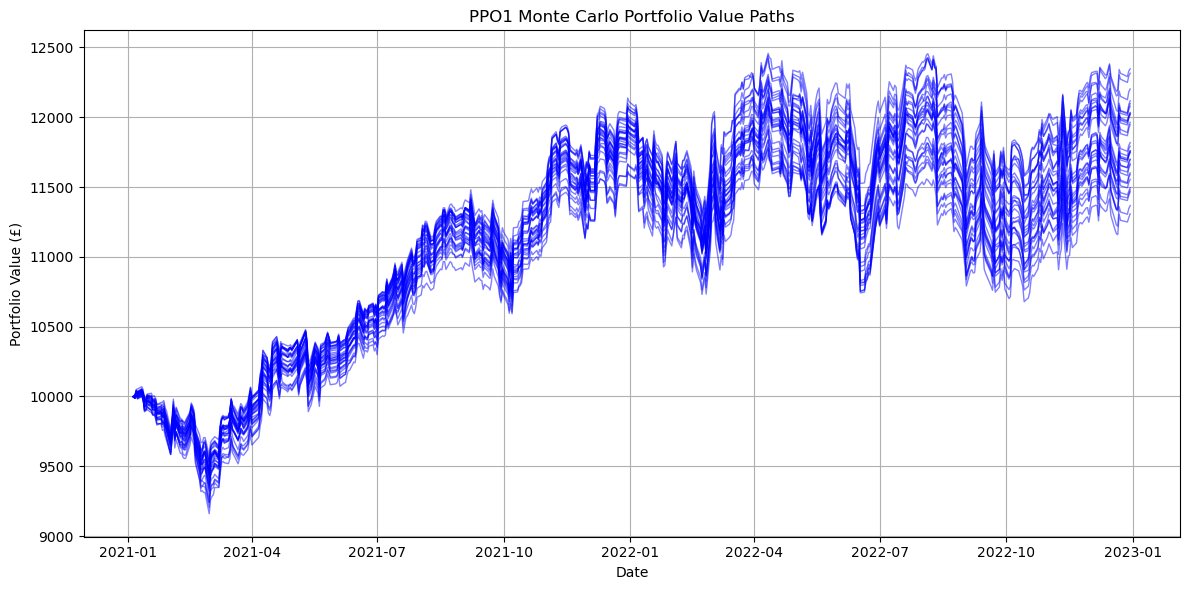

Cumulative return:  18.14201365020584 %
Sharpe ratio:  0.8053025864118587
Max drawdown:  -0.08681245809123973


{'cumulative_return': 0.1814201365020584,
 'sharpe': 0.8053025864118587,
 'max_drawdown': -0.08681245809123973}

In [87]:
results = train_and_evaluate_model(TradingEnv,assets,train_df,val_df)
analyse_results(results,'PPO1')

In [88]:
fine_tune_model(TradingEnv,assets,train_df,val_df,
                             trade_fraction=[0.025,0.05,0.075,0.1,0.125])

{'trade_fraction': 0.025} {'cumulative_return': 0.23577464437218223, 'sharpe': 0.9680871528722249, 'max_drawdown': -0.08741743194876966}
{'trade_fraction': 0.05} {'cumulative_return': 0.19096047075970318, 'sharpe': 0.83194380238196, 'max_drawdown': -0.0951532304206095}
{'trade_fraction': 0.075} {'cumulative_return': 0.1910561187203994, 'sharpe': 0.7834072077710447, 'max_drawdown': -0.10730977968299184}
{'trade_fraction': 0.1} {'cumulative_return': 0.2646397383991957, 'sharpe': 1.078388693556866, 'max_drawdown': -0.08494840810314949}
{'trade_fraction': 0.125} {'cumulative_return': 0.1347934950630973, 'sharpe': 0.5749240767357479, 'max_drawdown': -0.12884626852835862}


## Tuning the training process

Training the same model multiple times is giving very different results on the same data, suggesting problems with convergence, even though those results are often encouraging. Increasing training time could potentially help, but we are already training for 10000 steps on about 2000 rows of data, and training time is starting to become an issue. So I will try to tune the training hyperparameters to give more consistent results.

My idea is, for a given set of hyperparameters, I would like to train the model several times on train_df, run each one deterministically on val_df, and measure the distribution of cumulative returns and Sharpe ratio between runs. I will look for training hyperparameters that produce a high average return and Sharpe ratio, with low standard deviation.

In [89]:
def analyse_multi_training_results(results, model_name='', verbose=True):
    runs = len(results.columns)
    metrics = np.zeros((runs, 3))

    for n, col in enumerate(results.columns):
        metrics[n, :] = performance_metrics(results[col])

    metrics_df = pd.DataFrame(metrics,
        columns=["Cumulative Return", "Sharpe Ratio", "Max Drawdown"])
    summary = metrics_df.describe().loc[["mean", "std"]]

    # --- Plot ---
    if verbose:
        plt.figure(figsize=(12, 6))
        for col in results.columns:
            plt.plot(results.index, results[col], color='blue', alpha=0.5, linewidth=1)
        plt.title(f"{model_name} Multi-Training Portfolio Value Paths")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value (£)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(metrics_df.to_string(index=False))
        print(summary)

    return summary


def multi_training_runs(env_class,assets,train_data,test_data,
                       steps_per_run=10000,n_training=8,**kwargs):
    results=[]
    for i in range(n_training):
        train_env = DummyVecEnv([lambda: env_class(assets, train_data, **kwargs)])
        model = PPO("MlpPolicy", train_env, verbose=0, tensorboard_log="./ppo_logs",
                   **kwargs)
        model.learn(total_timesteps=steps_per_run)

        env = env_class(assets, test_data)
        obs = env.reset()
        done = False
        portfolio_values = []

        while not done:
            actions, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(actions)
            portfolio_values.append(info["portfolio_value"])
        results.append(portfolio_values)
        
    results = np.array(results).T
    results = pd.DataFrame(results,index=test_data.index[1:])
    
    return results

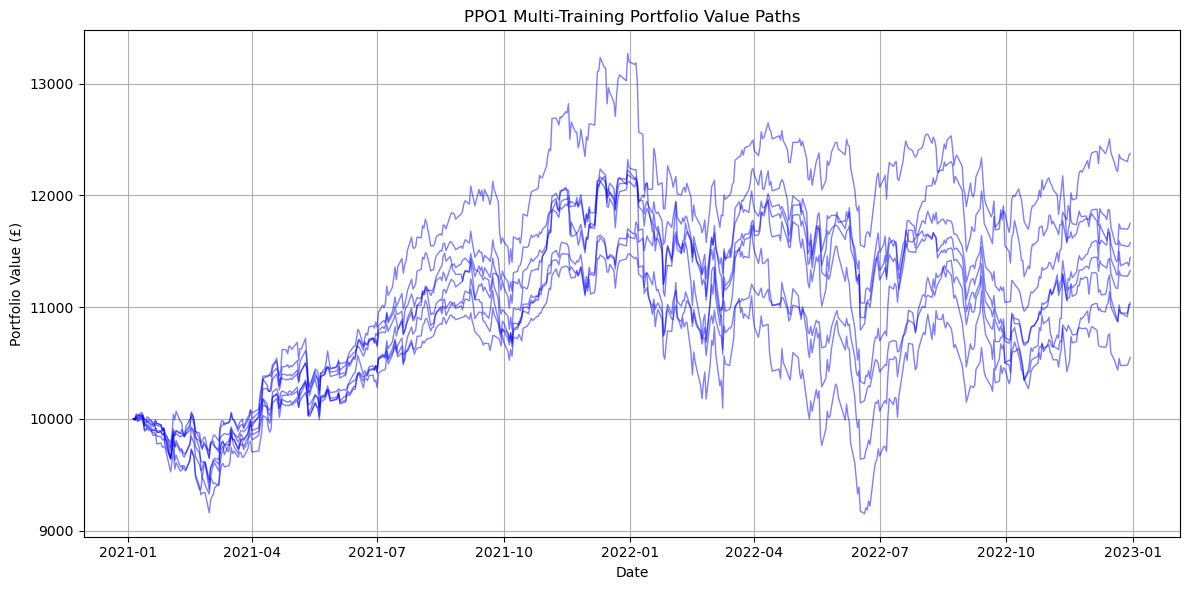

 Cumulative Return  Sharpe Ratio  Max Drawdown
            0.1328        0.5548       -0.1077
            0.2378        0.9032       -0.0909
            0.1754        0.7248       -0.1537
            0.1024        0.3831       -0.2573
            0.1043        0.3744       -0.2737
            0.1580        0.6388       -0.1134
            0.1446        0.5753       -0.1183
            0.0550        0.3079       -0.1166
      Cumulative Return  Sharpe Ratio  Max Drawdown
mean             0.1388        0.5578       -0.1539
std              0.0549        0.2002        0.0712


Cumulative Return  Sharpe Ratio  Max Drawdown
mean             0.1388        0.5578       -0.1539
std              0.0549        0.2002        0.0712

In [90]:
results = multi_training_runs(TradingEnv,assets,train_df,val_df)
analyse_multi_training_results(results,'PPO1')

In [91]:
def fine_tune_training(env_class,assets,train_data,test_data,
                             n_training=8,**kwargs):
    # Each kwargs should have a list of values to iterate through
    # which the PPO class or steps_per_run can take for that kwarg
    keys = list(kwargs.keys())
    values = [kwargs[kwarg] for kwarg in keys]
    grid = list(itertools.product(*values))
    for element in grid:
        params = dict(zip(keys,element))
        results = multi_training_runs(env_class,assets,train_data,test_data,**params)
        summary = analyse_multi_training_results(results,verbose=False)
        print(params)
        print(summary)

In [92]:
fine_tune_training(TradingEnv,assets,train_df,val_df,
                   steps_per_run=[20000,30000,40000])

{'steps_per_run': 20000}
      Cumulative Return  Sharpe Ratio  Max Drawdown
mean             0.1981        0.7456       -0.1247
std              0.0931        0.2645        0.0323
{'steps_per_run': 30000}
      Cumulative Return  Sharpe Ratio  Max Drawdown
mean             0.1739        0.6866       -0.1334
std              0.0827        0.3199        0.0543
{'steps_per_run': 40000}
      Cumulative Return  Sharpe Ratio  Max Drawdown
mean             0.1435        0.5786       -0.1612
std              0.0594        0.2425        0.0596


In [93]:
fine_tune_training(TradingEnv,assets,train_df,val_df,
                    steps_per_run=[30000],
                    learning_rate=[1e-4, 3e-4, 1e-3],
                    n_steps=[2048,4096])

{'steps_per_run': 30000, 'learning_rate': 0.0001, 'n_steps': 2048}
      Cumulative Return  Sharpe Ratio  Max Drawdown
mean             0.1549        0.5995       -0.1402
std              0.0828        0.2663        0.0517
{'steps_per_run': 30000, 'learning_rate': 0.0001, 'n_steps': 4096}
      Cumulative Return  Sharpe Ratio  Max Drawdown
mean             0.1481        0.5937       -0.1343
std              0.0927        0.3068        0.0545
{'steps_per_run': 30000, 'learning_rate': 0.0003, 'n_steps': 2048}
      Cumulative Return  Sharpe Ratio  Max Drawdown
mean             0.1738        0.6781       -0.1216
std              0.0492        0.1677        0.0391
{'steps_per_run': 30000, 'learning_rate': 0.0003, 'n_steps': 4096}
      Cumulative Return  Sharpe Ratio  Max Drawdown
mean             0.2390        0.8382       -0.1246
std              0.1390        0.3318        0.0409
{'steps_per_run': 30000, 'learning_rate': 0.001, 'n_steps': 2048}
      Cumulative Return  Sharpe Ratio  Max

## PPO2

For this model, I want to allow variable-sized trades. Since preliminary testing suggested that allowing too large trades impaired model performance, I will then fine-tune the maximum allowed size.

In [94]:
# 1. __init__: Initialise the environment
class VariableSizeTradingEnv(TradingEnv):
    def __init__(self, assets, data, initial_cash=10_000, transaction_cost=0.001, slippage=0.0005,trade_fraction=0.1):
        super(VariableSizeTradingEnv, self).__init__(assets, data,
                                                     initial_cash=initial_cash,
                                                     transaction_cost=transaction_cost,
                                                     slippage=slippage)

        self.action_space = spaces.Box(low=0, high=1, shape=(len(self.assets)+1,)) # >0 = Sell, <0 = Buy
        # +1 because the final number is going to represent the proportion of cash
        
        self.trade_fraction = trade_fraction
        # To be fine-tuned

    def buy_or_sell(self,actions,prices,prices_with_slip):
        portfolio_fractions = [0]*(len(self.assets)+1)
        # this will be the fraction of the total portfolio value held in each asset, and in cash
        for i in range(len(self.assets)):
            portfolio_fractions[i] = self.asset_holdings[i] * prices[i]/self.portfolio_value
        portfolio_fractions[-1] = self.cash/self.portfolio_value

        # Normalise actions safely
        action_sum = np.sum(actions)
        if action_sum == 0:
            actions = np.array([1.0 / len(actions)] * len(actions))
        else:
            actions = actions / action_sum
        
        # To reduce volatility, only go self.trade_fraction of the way from portfolio_fractions to actions
        new_fractions = [portfolio_fractions[i]+self.trade_fraction*(actions[i]-portfolio_fractions[i])
                         for i in range(len(self.assets)+1)]
        
        def sell(idx):
            # If the agent always sells everything, its behaviour becomes too volatile.
            # PPO (or any RL agent) learns better when actions have gradual effects — not all-or-nothing.
            # Sell
            value_to_sell = (portfolio_fractions[idx]-new_fractions[idx])*self.portfolio_value
            units_to_sell = value_to_sell/prices[idx]
            self.cash += units_to_sell * prices[idx] * (1 - self.transaction_cost)
            self.asset_holdings[idx] -= units_to_sell

        def buy(idx):
            # Buy
            value_to_buy = (new_fractions[idx]-portfolio_fractions[idx])*self.portfolio_value
            units_to_buy = value_to_buy/prices_with_slip[idx] * (1 - self.transaction_cost)
            self.asset_holdings[idx] += units_to_buy
            self.cash -= value_to_buy
        
        # Go through the sales first, then the buys, to make sure cash never goes negative
        for i in range(len(self.assets)):
            if actions[i] < portfolio_fractions[i]:
                sell(i)
        for i in range(len(self.assets)):
            if actions[i] > portfolio_fractions[i]:
                buy(i)

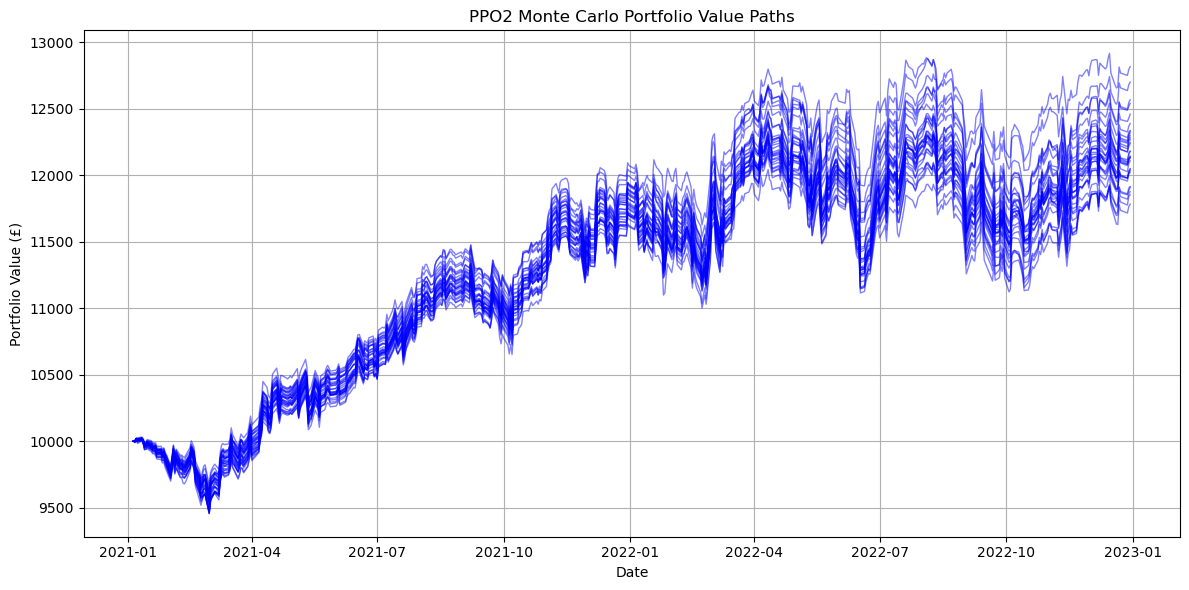

Cumulative return:  22.10821208488703 %
Sharpe ratio:  1.0188927405736803
Max drawdown:  -0.08133146892393019


{'cumulative_return': 0.22108212084887027,
 'sharpe': 1.0188927405736803,
 'max_drawdown': -0.08133146892393019}

In [95]:
results = train_and_evaluate_model(VariableSizeTradingEnv,assets,
                                   train_df,val_df,
                                  trade_fraction=0.05)
analyse_results(results,'PPO2')

In [96]:
fine_tune_model(VariableSizeTradingEnv,assets,train_df,val_df,
                             trade_fraction=[0.05,0.075,0.1,0.125,0.15])

{'trade_fraction': 0.05} {'cumulative_return': 0.20440145303188179, 'sharpe': 0.8825396476797406, 'max_drawdown': -0.09910699022466064}
{'trade_fraction': 0.075} {'cumulative_return': 0.19439196371120263, 'sharpe': 0.7853299249944696, 'max_drawdown': -0.12113804646765398}
{'trade_fraction': 0.1} {'cumulative_return': 0.24390554227062775, 'sharpe': 1.0180934905808756, 'max_drawdown': -0.09987462765177181}
{'trade_fraction': 0.125} {'cumulative_return': 0.2317040598988991, 'sharpe': 0.9662706157663074, 'max_drawdown': -0.10435734924456956}
{'trade_fraction': 0.15} {'cumulative_return': 0.33328109447949433, 'sharpe': 1.3049929075582793, 'max_drawdown': -0.07995151267950755}


## PPO3

Now we introduce risk management. VaR will come later. At this point, I adjust the reward function to discourage various risks. 

I am setting trade_fraction to 0.05 because that performed the best in the PPO2 fine-tuning.

In [97]:
class RiskManagedTradingEnv(VariableSizeTradingEnv):
    def __init__(self, assets, data, initial_cash=10_000,
                 transaction_cost=0.001, slippage=0.0005,
                trade_fraction=0.15,max_concentration=0.6,
                concentration_penalty=0.03):
        super(RiskManagedTradingEnv, self).__init__(
            assets, data, initial_cash=initial_cash,
            transaction_cost=transaction_cost,
            slippage=slippage,
            trade_fraction=trade_fraction)
        
        self.avg_buy_price = [0] * len(self.assets)
        self.max_drawdown_threshold = 0.1
        self.max_concentration = max_concentration
        self.concentration_penalty = concentration_penalty

    def buy_or_sell(self,actions,prices,prices_with_slip):
        portfolio_fractions = [0]*(len(self.assets)+1)
        # this will be the fraction of the total portfolio value held in each asset, and in cash
        for i in range(len(self.assets)):
            portfolio_fractions[i] = self.asset_holdings[i] * prices[i]/self.portfolio_value
        portfolio_fractions[-1] = self.cash/self.portfolio_value

        # Normalise actions safely
        action_sum = np.sum(actions)
        if action_sum == 0:
            actions = np.array([1.0 / len(actions)] * len(actions))
        else:
            actions = actions / action_sum
        
        # To reduce volatility, only go self.trade_fraction of the way from portfolio_fractions to actions
        new_fractions = [portfolio_fractions[i]+self.trade_fraction*(actions[i]-portfolio_fractions[i])
                         for i in range(len(self.assets)+1)]
        
        def sell(idx):
            # If the agent always sells everything, its behaviour becomes too volatile.
            # PPO (or any RL agent) learns better when actions have gradual effects — not all-or-nothing.
            # Sell
            value_to_sell = (portfolio_fractions[idx]-new_fractions[idx])*self.portfolio_value
            units_to_sell = value_to_sell/prices[idx]
            self.cash += units_to_sell * prices[idx] * (1 - self.transaction_cost)
            self.asset_holdings[idx] -= units_to_sell

        def buy(idx):
            # Buy
            value_to_buy = (new_fractions[idx]-portfolio_fractions[idx])*self.portfolio_value
            units_to_buy = value_to_buy/prices_with_slip[idx] * (1 - self.transaction_cost)
            self.asset_holdings[idx] += units_to_buy
            self.cash -= value_to_buy
            
            if self.asset_holdings[idx] > 0:
                total_cost = self.asset_holdings[idx] * self.avg_buy_price[idx]
                new_cost = units_to_buy * prices_with_slip[idx]
                total_units = self.asset_holdings[idx] + units_to_buy
                self.avg_buy_price[idx] = (total_cost + new_cost) / total_units
            else:
                self.avg_buy_price[idx] = prices_with_slip[idx]
        
        # Go through the sales first, then the buys, to make sure cash never goes negative
        for i in range(len(self.assets)):
            if actions[i] < portfolio_fractions[i]:
                sell(i)
        for i in range(len(self.assets)):
            if actions[i] > portfolio_fractions[i]:
                buy(i)
    
    def shape_reward(self,prices):
        reward = 0

        # Stop-loss / take-profit
        for i in range(len(self.assets)):
            if self.asset_holdings[i] > 0:
                current_price = prices[i]
                gain = (current_price - self.avg_buy_price[i]) / (self.avg_buy_price[i]+1e-8)
                if gain <= -0.1 or gain >= 0.2:
                    self.cash += self.asset_holdings[i] * prices[i] * (1 - self.transaction_cost) * self.trade_fraction
                    self.asset_holdings[i] *= 1-self.trade_fraction

        # Update portfolio value
        old_value = self.portfolio_value
        self.portfolio_value = self.cash + sum(
            self.asset_holdings[i] * prices[i] for i in range(len(self.assets))
        )

        raw_return = (self.portfolio_value - old_value) / (old_value + 1e-8)
        penalty = max(0, -raw_return)
        reward += raw_return - 0.2 * penalty

        # Risk constraints
        portfolio_fractions_after = [
            self.asset_holdings[i] * prices[i] / self.portfolio_value for i in range(len(self.assets))
        ]
        exposure = sum(portfolio_fractions_after)
        if exposure > 1.0:
            reward -= 0.05 * (exposure - 1.0)

        concentration = max(portfolio_fractions_after)
        if concentration > self.max_concentration:
            reward -= self.concentration_penalty * (concentration - self.max_concentration)

        drawdown = (old_value - self.portfolio_value) / old_value
        if drawdown > self.max_drawdown_threshold:
            reward -= 0.1 * (drawdown - self.max_drawdown_threshold)
        
        info = {'portfolio_value': self.portfolio_value}
        
        return reward, info

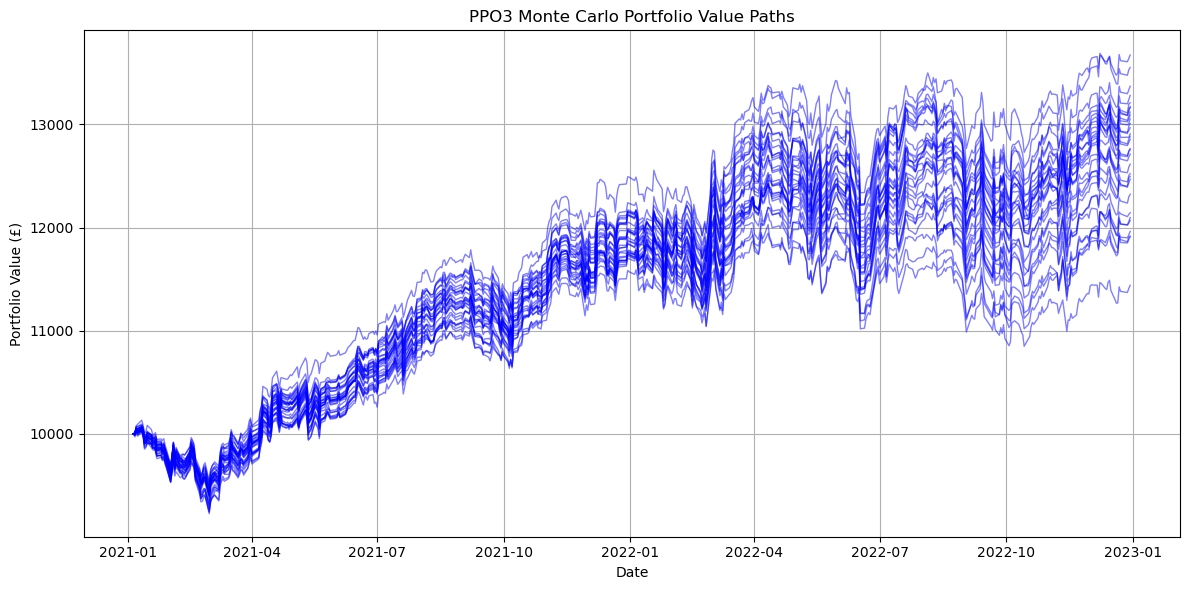

Cumulative return:  27.19191964786818 %
Sharpe ratio:  1.13135970216087
Max drawdown:  -0.08195202171121739


{'cumulative_return': 0.2719191964786818,
 'sharpe': 1.13135970216087,
 'max_drawdown': -0.08195202171121739}

In [98]:
results = train_and_evaluate_model(RiskManagedTradingEnv,assets,
                                   train_df,val_df)
analyse_results(results,'PPO3')

Preliminary testing suggests that the main effect of these new risk management constraints comes via the penalty for having >60% invested in one asset. So I will fine-tune the hyperparameters for this penalty.

In [99]:
fine_tune_model(RiskManagedTradingEnv,assets,train_df,val_df,
                max_concentration=[0.5,0.6,0.7,0.8],
                concentration_penalty=[0.005,0.01,0.02,0.03,0.04])

{'max_concentration': 0.5, 'concentration_penalty': 0.005} {'cumulative_return': 0.3081079966605284, 'sharpe': 1.249777501694761, 'max_drawdown': -0.07986613133723912}
{'max_concentration': 0.5, 'concentration_penalty': 0.01} {'cumulative_return': 0.25241660948718087, 'sharpe': 1.0978125707485449, 'max_drawdown': -0.09020600689756503}
{'max_concentration': 0.5, 'concentration_penalty': 0.02} {'cumulative_return': 0.2632958609663421, 'sharpe': 1.0375178182600726, 'max_drawdown': -0.08704573734516512}
{'max_concentration': 0.5, 'concentration_penalty': 0.03} {'cumulative_return': 0.3313593881264812, 'sharpe': 1.3622282817033053, 'max_drawdown': -0.08217057585781376}
{'max_concentration': 0.5, 'concentration_penalty': 0.04} {'cumulative_return': 0.24667101531412738, 'sharpe': 0.9752686752804045, 'max_drawdown': -0.0951275037749593}
{'max_concentration': 0.6, 'concentration_penalty': 0.005} {'cumulative_return': 0.2580775870246745, 'sharpe': 1.0938578140691857, 'max_drawdown': -0.072512707

The best-performing hyperparameters are max_concentration=0.5, concentration_penalty=0.03, giving an impressive return of 33.1%. This is considerably better than PPO2 without the risk management constraints, which is surprising, suggesting that PPO2's additional risk-taking behaviour was actually harming its bottom line. The additional stability is not only reducing risk, but moving us closer to the Pareto frontier.

## PPO4

Now I will add a VaR-derived term to the reward function.

In [100]:
class VARTradingEnv(RiskManagedTradingEnv):
    def __init__(self, assets, data, initial_cash=10_000,
                 transaction_cost=0.001, slippage=0.0005,
                trade_fraction=0.15,max_concentration=0.5,
                concentration_penalty=0.03,
                 lookback=30, var_budget=0.05,var_penalty=0.1):
        super(VARTradingEnv, self).__init__(assets, data,
                initial_cash=initial_cash,
                transaction_cost=transaction_cost,
                slippage=slippage,
                trade_fraction=trade_fraction,
                max_concentration=max_concentration,
                concentration_penalty=concentration_penalty)

        self.lookback = lookback
        self.var_budget = var_budget
        self.var_penalty = var_penalty

    def compute_portfolio_var(self):
        if self.step_idx < self.lookback:
            return 0

        returns = []
        for asset in self.assets:
            ret_series = self.data[f"{asset}_LOGRET"].iloc[self.step_idx - self.lookback:self.step_idx].values
            returns.append(ret_series)

        returns = np.array(returns)
        weights = np.array([
            (self.asset_holdings[i] * self.data.iloc[self.step_idx][self.assets[i]]) / self.portfolio_value
            for i in range(len(self.assets))
        ])

        portfolio_returns = np.dot(weights, returns)
        mean = np.mean(portfolio_returns)
        std = np.std(portfolio_returns)
        z = norm.ppf(1-self.var_budget)
        var = (mean + z * std) * self.portfolio_value
        return var
    
    def shape_reward(self,prices):
        reward = 0

        # Stop-loss / take-profit
        for i in range(len(self.assets)):
            if self.asset_holdings[i] > 0:
                current_price = prices[i]
                gain = (current_price - self.avg_buy_price[i]) / (self.avg_buy_price[i]+1e-8)
                if gain <= -0.1 or gain >= 0.2:
                    self.cash += self.asset_holdings[i] * prices[i] * (1 - self.transaction_cost) * self.trade_fraction
                    self.asset_holdings[i] *= 1-self.trade_fraction

        # Update portfolio value
        old_value = self.portfolio_value
        self.portfolio_value = self.cash + sum(
            self.asset_holdings[i] * prices[i] for i in range(len(self.assets))
        )

        raw_return = (self.portfolio_value - old_value) / (old_value + 1e-8)
        penalty = max(0, -raw_return)
        reward += raw_return - 0.2 * penalty
        
        # New VaR constraint
        var = self.compute_portfolio_var()
        if var > self.var_budget*self.portfolio_value:
            reward -= self.var_penalty*(var/(self.var_budget*self.portfolio_value)-1)

        # Risk constraints
        portfolio_fractions_after = [
            self.asset_holdings[i] * prices[i] / self.portfolio_value for i in range(len(self.assets))
        ]
        exposure = sum(portfolio_fractions_after)
        if exposure > 1.0:
            reward -= 0.05 * (exposure - 1.0)

        concentration = max(portfolio_fractions_after)
        if concentration > self.max_concentration:
            reward -= self.concentration_penalty * (concentration - self.max_concentration)

        drawdown = (old_value - self.portfolio_value) / old_value
        if drawdown > self.max_drawdown_threshold:
            reward -= 0.1 * (drawdown - self.max_drawdown_threshold)
        
        info = {'portfolio_value': self.portfolio_value}
        
        return reward, info

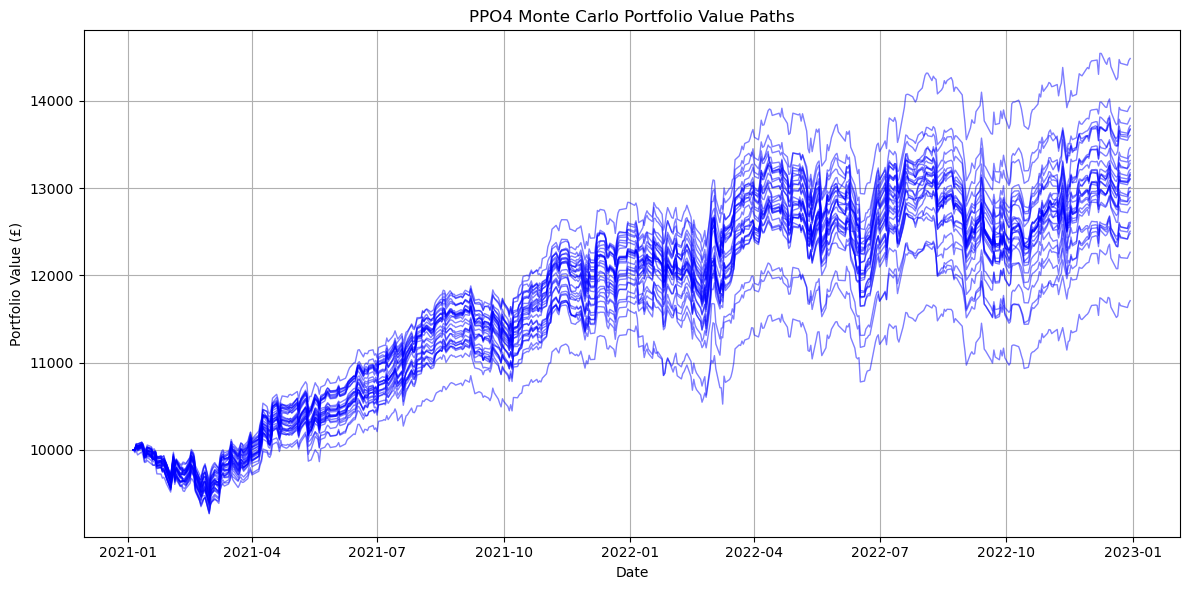

Cumulative return:  31.177361037907218 %
Sharpe ratio:  1.3007978926612977
Max drawdown:  -0.07813187645445438


{'cumulative_return': 0.3117736103790722,
 'sharpe': 1.3007978926612977,
 'max_drawdown': -0.07813187645445438}

In [101]:
results = train_and_evaluate_model(VARTradingEnv,assets,
                                   train_df,val_df)
analyse_results(results,'PPO4')

It looks like adding VaR as a constraint has affected performance to some extent, reducing cumulative returns from 20% to 10%; the Sharpe ratio has also decreased. There are several hyperparameters associated to the VaR constraint I would like to tune, aiming to limit this decrease in returns to an acceptable amount. [Something about the Sharpe ratio too.]

In [102]:
fine_tune_model(VARTradingEnv,assets,train_df,val_df,
                var_budget=[0.025,0.05,0.075,0.1],
                lookback=[30,60])

{'var_budget': 0.025, 'lookback': 30} {'cumulative_return': 0.2587210153541059, 'sharpe': 1.060473519512611, 'max_drawdown': -0.08520724160246093}
{'var_budget': 0.025, 'lookback': 60} {'cumulative_return': 0.24204903574466727, 'sharpe': 1.070147078153588, 'max_drawdown': -0.07977737858961641}
{'var_budget': 0.05, 'lookback': 30} {'cumulative_return': 0.24482146719572484, 'sharpe': 1.0858610897760996, 'max_drawdown': -0.0766848958547503}
{'var_budget': 0.05, 'lookback': 60} {'cumulative_return': 0.2238659337117896, 'sharpe': 1.0578293261635447, 'max_drawdown': -0.08996872655415258}
{'var_budget': 0.075, 'lookback': 30} {'cumulative_return': 0.25646136114446966, 'sharpe': 1.1201014490757906, 'max_drawdown': -0.08208451695336773}
{'var_budget': 0.075, 'lookback': 60} {'cumulative_return': 0.37009008984623865, 'sharpe': 1.406972187549143, 'max_drawdown': -0.08272790168032582}
{'var_budget': 0.1, 'lookback': 30} {'cumulative_return': 0.27888423624627995, 'sharpe': 1.257242336901977, 'max_d

The best performing hyperparameters are var_budget=0.075, lookback=60, with impressive returns and Sharpe ratio. (As this is in a corner of our grid search, we could consider looking further.)

## Testing on test_df

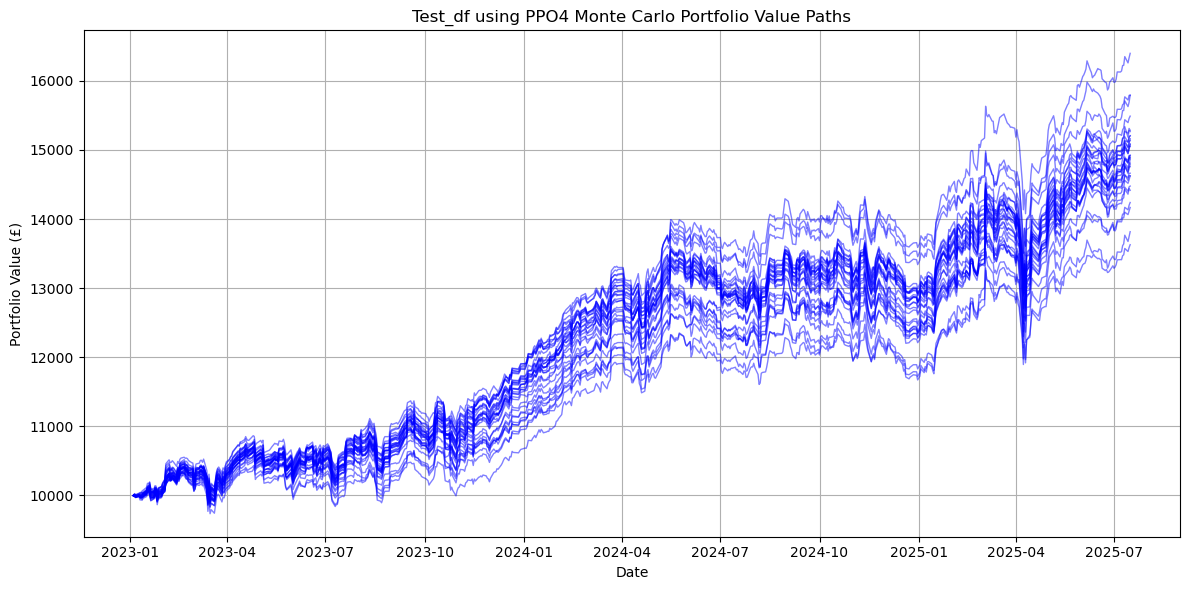

Cumulative return:  49.18512948983327 %
Sharpe ratio:  1.592325576593692
Max drawdown:  -0.09671559785737922


{'cumulative_return': 0.49185129489833274,
 'sharpe': 1.592325576593692,
 'max_drawdown': -0.09671559785737922}

In [103]:
ppo4_results, ppo4_model = train_and_evaluate_model(VARTradingEnv,assets,
                                   train_df,test_df,
                                   var_budget=0.075,lookback=60)
analyse_results(ppo4_results,'Test_df using PPO4')

In [192]:
ppo4_model.save("ppo4_var0075_lb60.zip")

# Load saved model
loaded_model = PPO.load("ppo4_var0075_lb60.zip")



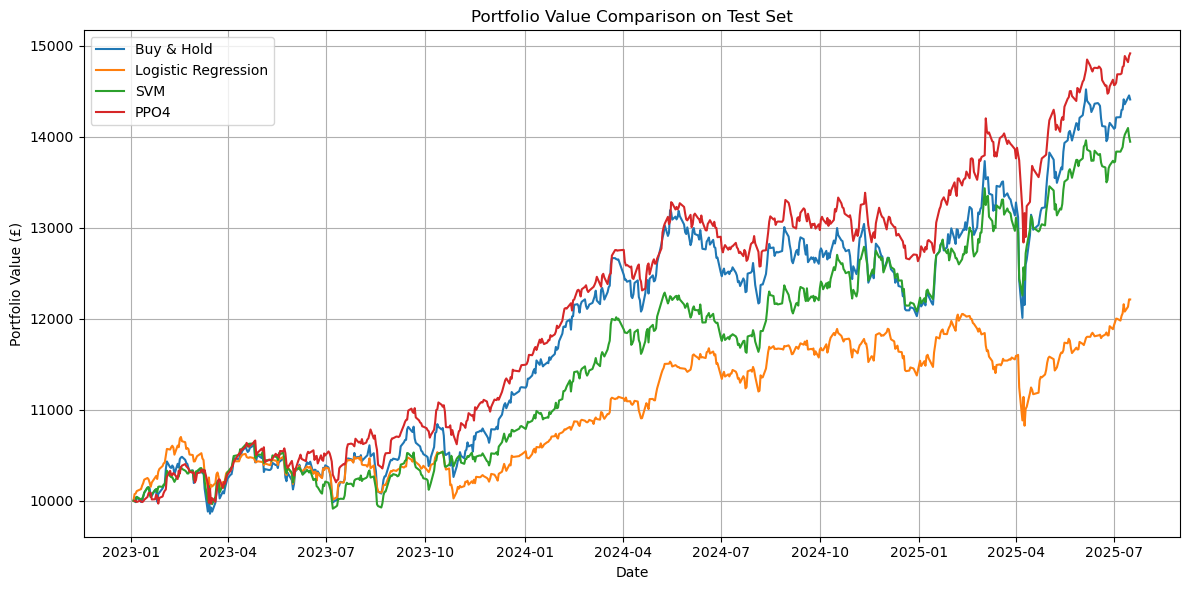

In [104]:
plt.figure(figsize=(12, 6))
# Plot each baseline model
plt.plot(bnh_series, label="Buy & Hold")
plt.plot(lr_portfolio_total, label="Logistic Regression")
plt.plot(svm_portfolio_total, label="SVM")
# PPO model 
plt.plot(ppo4_results.mean(axis=1), label="PPO4")
plt.title("Portfolio Value Comparison on Test Set")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (£)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Stress Test Evaluation 

### Buy and Hold on the stress set

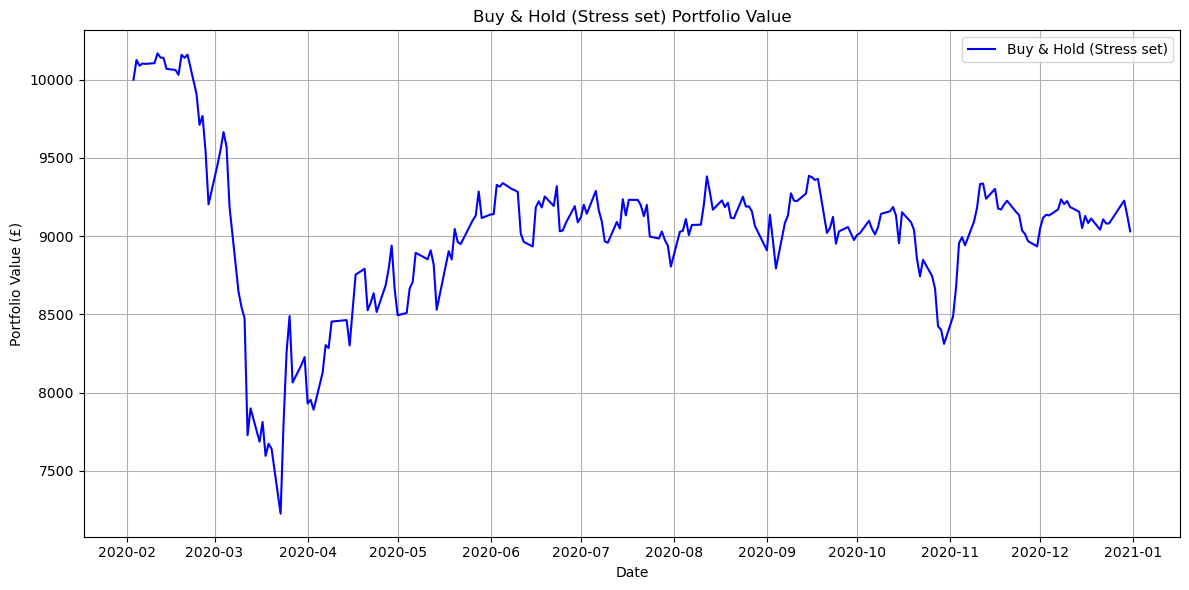

Buy & Hold (Stress set) Metrics
Cumulative return:  -9.690495853371358 %
Sharpe ratio:  -0.2605230996690953
Max drawdown:  -0.28931350445012005


In [255]:
# Run Buy & Hold strategy on the stress set 
bnh_stress_series = buy_and_hold_series(stress_df, assets)

# Performance evaluation on stress set
bnh_stress_metrics = analyse_single_series(bnh_stress_series, model_name="Buy & Hold (Stress set)")


### Logistic Regression on the Stress set

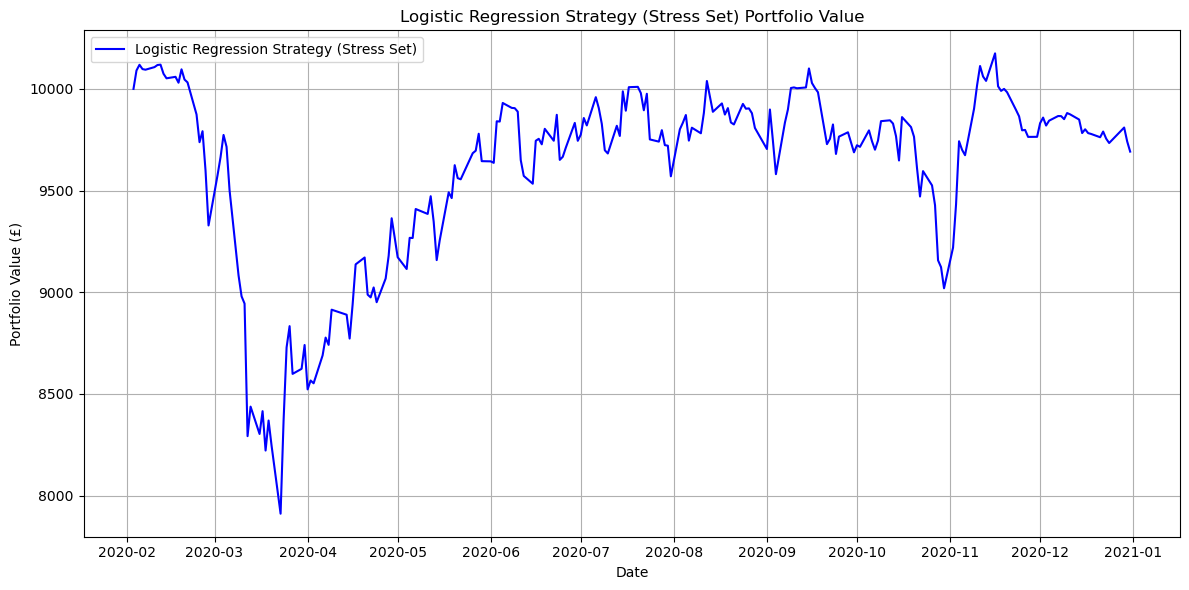

Logistic Regression Strategy (Stress Set) Metrics
Cumulative return:  -3.0845837589275833 %
Sharpe ratio:  -0.04715908404750684
Max drawdown:  -0.21824791147472866


In [41]:
lr_results_stress = train_final_models(train_df, stress_df, assets)

# --- STEP 3: Simulate trading for each asset ---
lr_portfolios_stress = {}
for asset, res in lr_results_stress.items():
    lr_portfolios_stress[asset] = simulate_logistic_strategy(stress_df, asset, res["predictions"])

# --- STEP 4: Equal-weighted portfolio ---
lr_portfolio_total_stress = pd.DataFrame(lr_portfolios_stress).mean(axis=1)

# --- STEP 5: Evaluate performance ---
lr_metrics_stress = analyse_single_series(lr_portfolio_total_stress, model_name="Logistic Regression Strategy (Stress Set)")


### SVM on the Stress set

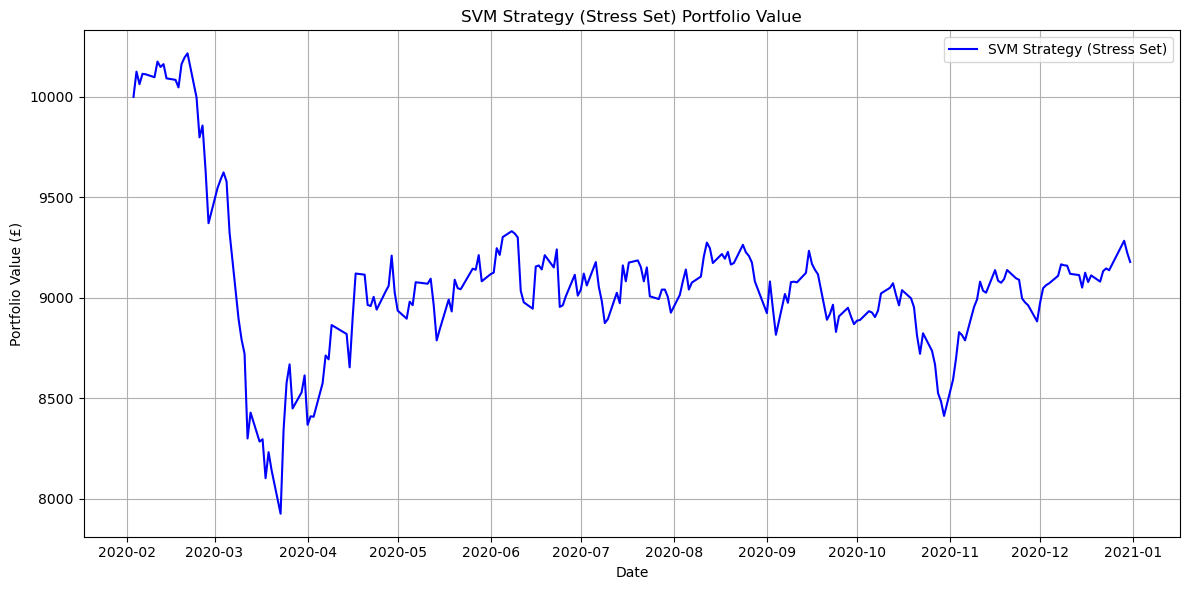

SVM Strategy (Stress Set) Metrics
Cumulative return:  -8.212194206086915 %
Sharpe ratio:  -0.3794589245480534
Max drawdown:  -0.22416589212554094


In [47]:
# Evaluate on Stress Set
svm_results_stress = train_final_svm_models(train_df, stress_df, assets, best_params)

svm_portfolios_stress = {}
for asset, res in svm_results_stress.items():
    svm_portfolios_stress[asset] = simulate_svm_strategy(stress_df, asset, res["predictions"])

svm_portfolio_total_stress = pd.DataFrame(svm_portfolios_stress).mean(axis=1)
svm_metrics_stress = analyse_single_series(svm_portfolio_total_stress, model_name="SVM Strategy (Stress Set)")

### PPO4 - PPO final on the Stress set

In [168]:
# Stress test evaluation (e.g. during COVID crash)
ppo4_stress_results = train_and_evaluate_model(VARTradingEnv, assets, train_df, stress_df,
                                               var_budget=0.1,lookback=30)

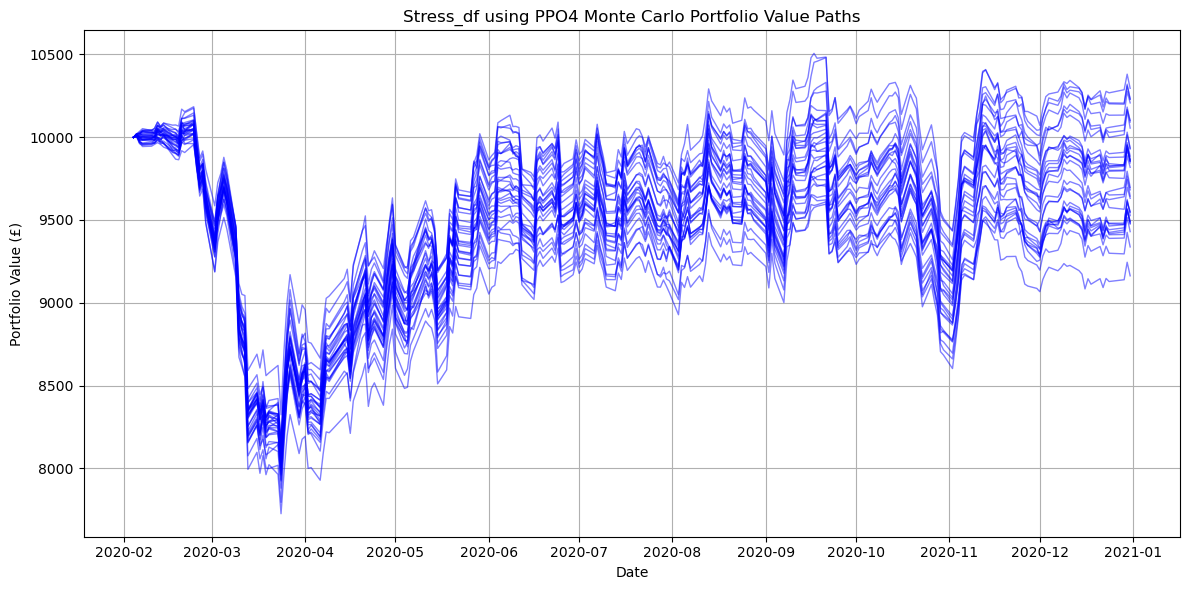

Cumulative return:  -2.2559569389388914 %
Sharpe ratio:  -0.02148464591778386
Max drawdown:  -0.20148732038834993


{'cumulative_return': -0.022559569389388915,
 'sharpe': -0.02148464591778386,
 'max_drawdown': -0.20148732038834993}

In [169]:
analyse_results(ppo4_stress_results,'Stress_df using PPO4')

### Evaluate the Baselines and the final PPO on the Stress set

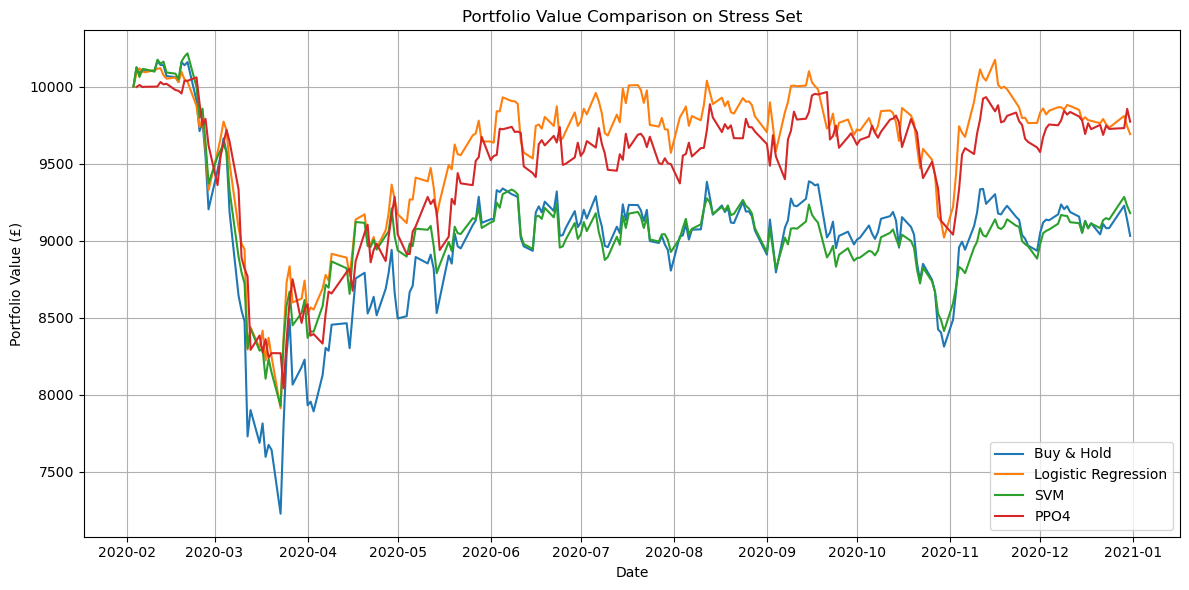

In [171]:
plt.figure(figsize=(12, 6))
# Plot each baseline model
plt.plot(bnh_stress_series, label="Buy & Hold")
plt.plot(lr_portfolio_total_stress, label="Logistic Regression")
plt.plot(svm_portfolio_total_stress, label="SVM")
# PPO model 
plt.plot(ppo4_stress_results.mean(axis=1), label="PPO4")
plt.title("Portfolio Value Comparison on Stress Set")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (£)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Paper Trading

In [268]:
def simulate_ppo_paper_trading(env, ppo_model, price_df):
    obs = env.reset()
    done = False

    portfolio_values = []

    while not done:
        action, _ = ppo_model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        portfolio_values.append(info["portfolio_value"])

    # directly use the last N dates from paper_df
    idx = price_df.index[-len(portfolio_values):]

    return pd.Series(portfolio_values, index=idx, name="Portfolio Value")


In [276]:
paper_size = int(len(test_df) * 0.2)
paper_df = test_df.tail(paper_size)

paper_env = VARTradingEnv(assets, paper_df, var_budget=0.075, lookback=60)
paper_curve = simulate_ppo_paper_trading(paper_env, ppo4_model, paper_df)

print(len(paper_curve), len(paper_curve.index))
print(paper_curve.index[:5])  


127 127
DatetimeIndex(['2025-01-15', '2025-01-16', '2025-01-17', '2025-01-20',
               '2025-01-21'],
              dtype='datetime64[ns]', name='Date', freq=None)


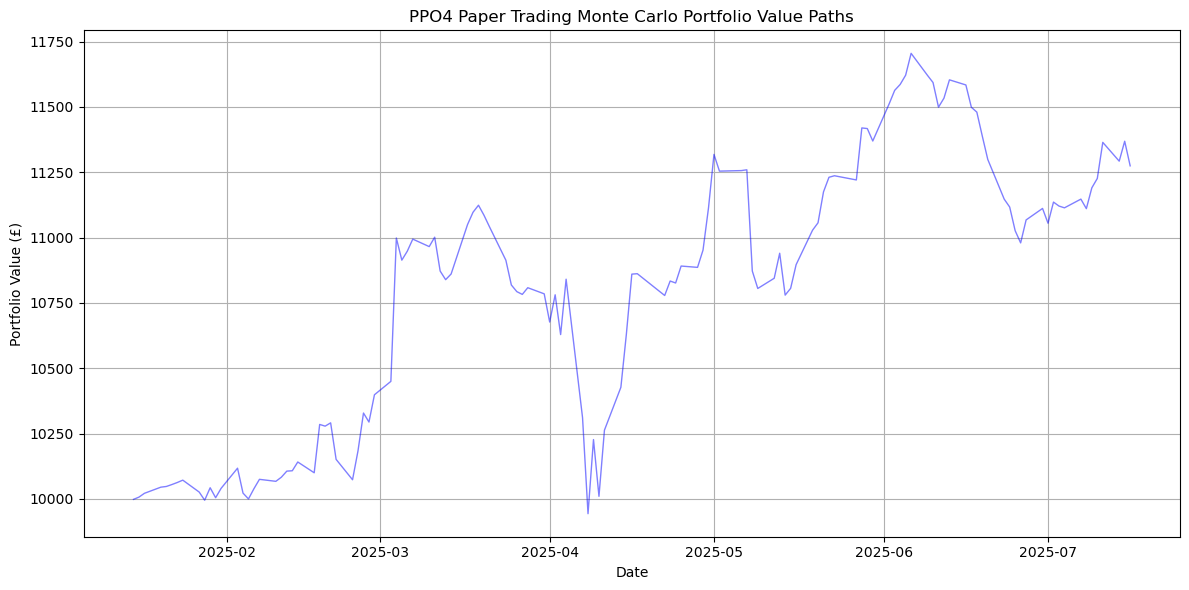

Cumulative return:  12.764030018509118 %
Sharpe ratio:  1.4024883699762882
Max drawdown:  -0.10610687135273922


{'cumulative_return': 0.12764030018509118,
 'sharpe': 1.4024883699762882,
 'max_drawdown': -0.10610687135273922}

In [277]:
analyse_results(pd.DataFrame(paper_curve), "PPO4 Paper Trading")
